In [ ]:
import numpy as np
import yfinance as yf
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from sklearn.preprocessing import MinMaxScaler, RobustScaler
import pandas as pd
from collections import deque
import os
from google.colab import drive
from sklearn.metrics import r2_score
drive.mount('/content/drive')


Mounted at /content/drive


# Data Preprocessing

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/MergedDataSectorPrognosis.xlsx')
economicData = pd.read_excel('/content/drive/MyDrive/EconomicDataforModel.xlsx', sheet_name='FullData')

df = df.loc[:, ~df.columns.str.startswith('Energy')].copy()
df = df.loc[:, ~df.columns.str.startswith('Communications')].copy()
df = df.loc[:, ~df.columns.str.startswith('IT')].copy()



df["Date"] = pd.to_datetime(df["Date"])
economicData["Date"] = pd.to_datetime(economicData["Date"])
merged_df = pd.merge(df, economicData, on="Date", how="inner")
merged_df = merged_df.dropna()

targets = 6

merged_df = merged_df.dropna()
month = np.float32(df["Date"].dt.month / 12)
merged_df.insert(targets+1, "Month", month)
merged_df = merged_df.drop(columns=["Date"])
print(merged_df.head())





   HealthCare  Materials  Industrials  ConsumerStaples  ConsumerDiscretionary  \
0     4609.52     529.77      1115.65           853.65              1831.1637   
1     4657.95     527.90      1117.17           852.53              1849.3140   
2     4709.40     535.06      1128.17           862.90              1879.2100   
3     4780.84     538.15      1137.39           867.98              1915.5290   
4     4777.09     539.13      1136.69           867.68              1927.8730   

   Utilities  Month  HealthCare Performance  Materials Performance  \
0     384.95    1.0                0.231673               0.360972   
1     385.42    1.0                0.270584               0.352868   
2     386.91    1.0                0.303174               0.366967   
3     388.04    1.0                0.322908               0.368594   
4     389.10    1.0                0.330797               0.374975   

   Industrials Performance  ...  UnemploymentRate  CPI  CoreCPI  CorePCE  PPI  \
0          

In [ ]:
fullarray = merged_df.values


windowsize = 2000
testsplit = 0.2

start, end = -windowsize,0
data = []
windows = 0
while start > -len(fullarray):
  windows += 1
  if end == 0:
    arr = fullarray[start:, :]
  else:
    arr = fullarray[start:end, :]

  end -= int(windowsize * testsplit)
  start -= int(windowsize * testsplit)


  scaler = MinMaxScaler()
  arr[:, targets:] = scaler.fit_transform(arr[:, targets:])

  x = []
  y = []

  timeframe = 250

  for i in range(len(arr)-timeframe):
      current = arr[i]
      halfyearPrior = arr[i+int(timeframe*1/2)]
      yearPrior = arr[i+int(timeframe)]
      y.append((current[:targets] - yearPrior[:targets]) / yearPrior[:targets])
      x.append(np.concatenate([halfyearPrior[targets:], yearPrior[targets:]]))

  x = np.array(x, dtype=np.float32)
  y = np.array(y, dtype=np.float32)

  x = np.array(x, dtype=np.float32)
  y = np.array(y, dtype=np.float32)

  n = int(len(x) * testsplit)

  xte = x[:n]
  yte = y[:n]
  xtr = x[n:]
  ytr = y[n:]


  xtr = torch.from_numpy(xtr).float()  # Ensure float32
  ytr = torch.from_numpy(ytr).float()
  xte = torch.from_numpy(xte).float()
  yte = torch.from_numpy(yte).float()

  data.append((xtr, ytr, xte, yte))


torch.Size([1400, 97])
torch.Size([1400, 6])
torch.Size([350, 97])
torch.Size([350, 6])
tensor([0.3054, 0.2879, 0.1705, 0.0980, 0.1936, 0.1979])
tensor([0.5455, 0.4258, 0.6503, 0.5181, 0.4847, 0.3316, 0.4576, 0.8424, 0.9139,
        0.8540, 0.7586, 0.6501, 0.2950, 0.8589, 0.7373, 0.9136, 0.5299, 0.7307,
        0.4565, 0.9206, 0.3043, 0.7311, 0.9923, 0.6998, 0.2125, 0.3296, 0.7715,
        0.6973, 0.0000, 0.6322, 0.7503, 0.1560, 0.6632, 0.4522, 0.2886, 0.6472,
        0.8033, 0.1579, 0.1439, 0.1046, 0.4319, 0.0542, 0.5864, 0.1649, 0.1665,
        0.3271, 0.0298, 0.2829, 0.4862, 0.5919, 0.2463, 0.5211, 0.4860, 0.4708,
        0.4528, 0.5753, 0.5457, 0.4484, 0.7256, 0.7519, 0.7414, 0.4454, 0.5208,
        0.5885, 0.2099, 0.4892, 0.6368, 0.6579, 0.7490, 0.9703, 0.3007, 0.6935,
        0.7866, 0.0676, 0.6410, 0.4826, 0.5535, 0.9078, 0.1895, 0.4754, 0.2069,
        0.3726, 0.2561, 0.7490, 0.2639, 0.2402, 0.3483, 0.2759, 0.6667, 0.8889,
        0.9480, 0.5391, 0.6379, 0.7574, 0.7563, 0.6837,

# Model Architecture

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ResidualBlock, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.linear = nn.Linear(input_size, hidden_size)
        nn.init.kaiming_uniform_(self.linear.weight, mode='fan_in', nonlinearity='relu')
        self.linear.bias.data.zero_()
        self.bn = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(p=0.4)
        self.relu = nn.ReLU()

        self.projection = None
        if input_size != hidden_size:
            self.projection = nn.Linear(input_size, hidden_size)

    def forward(self, x):
        residual = x
        out = self.linear(x)
        out = self.bn(out)
        out = self.dropout(out)
        out = self.relu(out)

        # Apply projection if input and hidden sizes differ
        if self.projection:
            residual = self.projection(residual)

        # Apply residual connection
        out = out + residual
        return out

class Net(nn.Module):
    def __init__(self, input_size, hidden_size=256, num_hid_layers=5):
        super(Net, self).__init__()

        self.layers = nn.ModuleList()
        for i in range(num_hid_layers):
            if i == 0:
                self.layers.append(ResidualBlock(input_size, hidden_size))
            else:
                self.layers.append(ResidualBlock(hidden_size, hidden_size))

        self.output_layer = nn.Linear(hidden_size, targets)
        with torch.no_grad():
            self.output_layer.weight *= 0.1  # Scale weights by 0.01
            if self.output_layer.bias is not None:
              self.output_layer.bias.zero_()

    def forward(self, x):
        # Pass through residual blocks
        for layer in self.layers:
            x = layer(x)

        return self.output_layer(x)  # Apply the output layer

    def predict(self, x):
        with torch.no_grad():
            out = self.forward(x)
        return out

# Train Model

Window 0



Step 0.0/5.0, Loss: 0.200930
Step 1.0/5.0, Loss: 0.053683
Step 2.0/5.0, Loss: 0.039076
Step 3.0/5.0, Loss: 0.035011
Step 4.0/5.0, Loss: 0.032134
Step 4.999/5.0, Loss: 0.030259


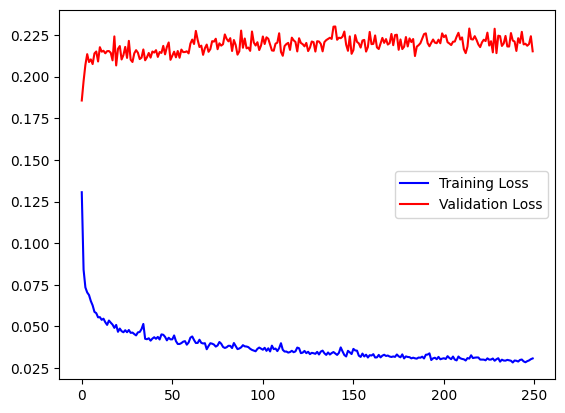

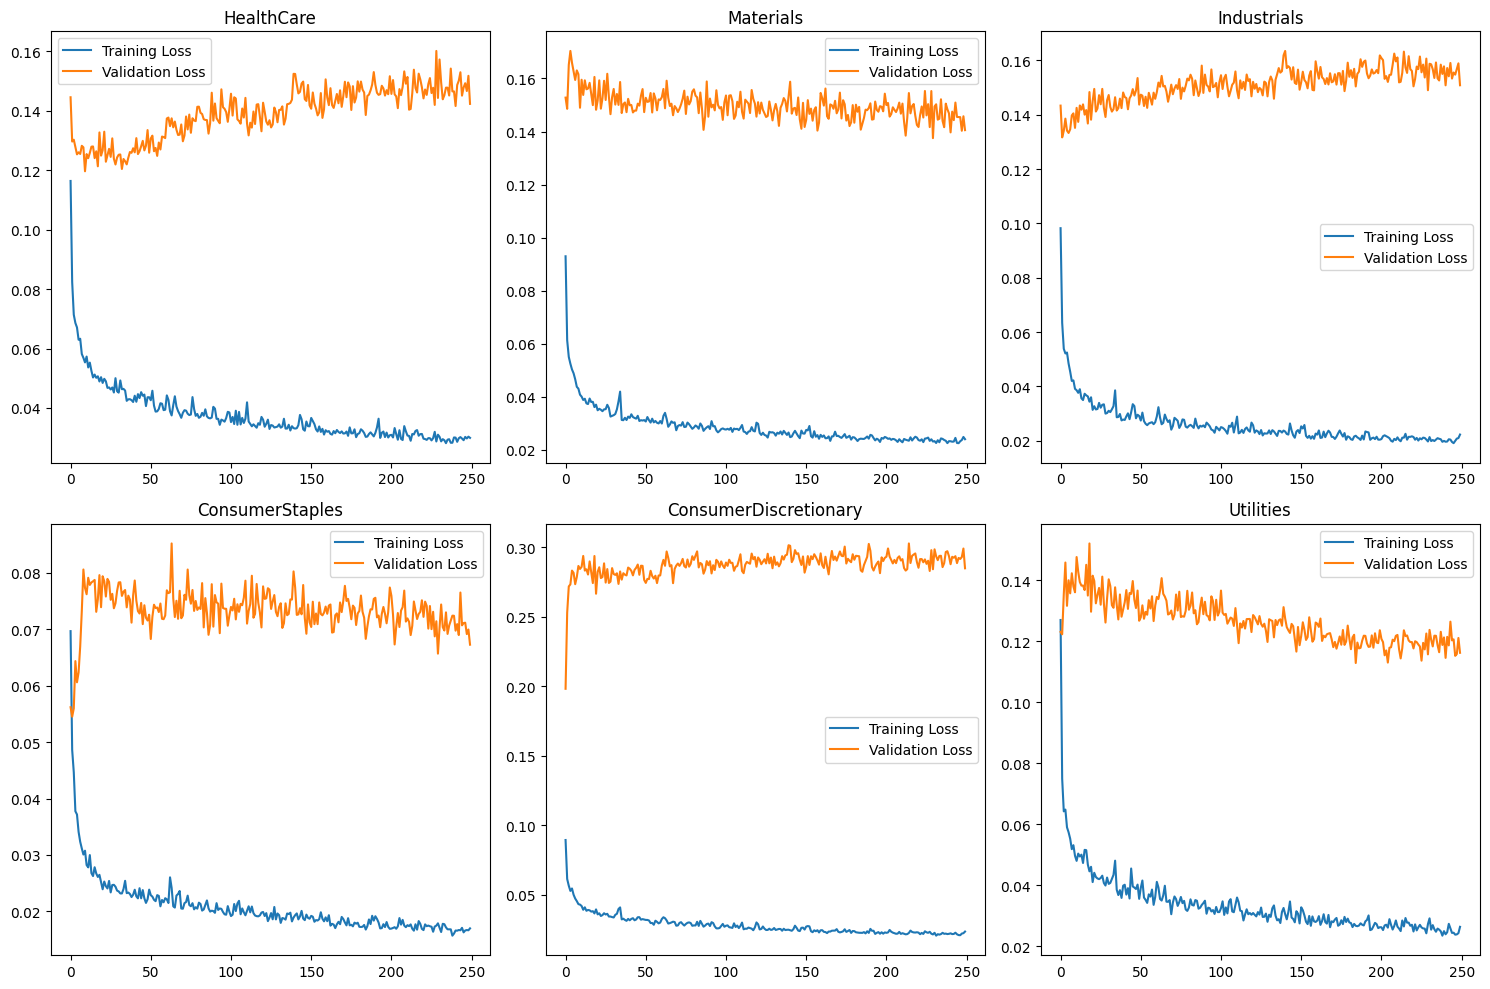

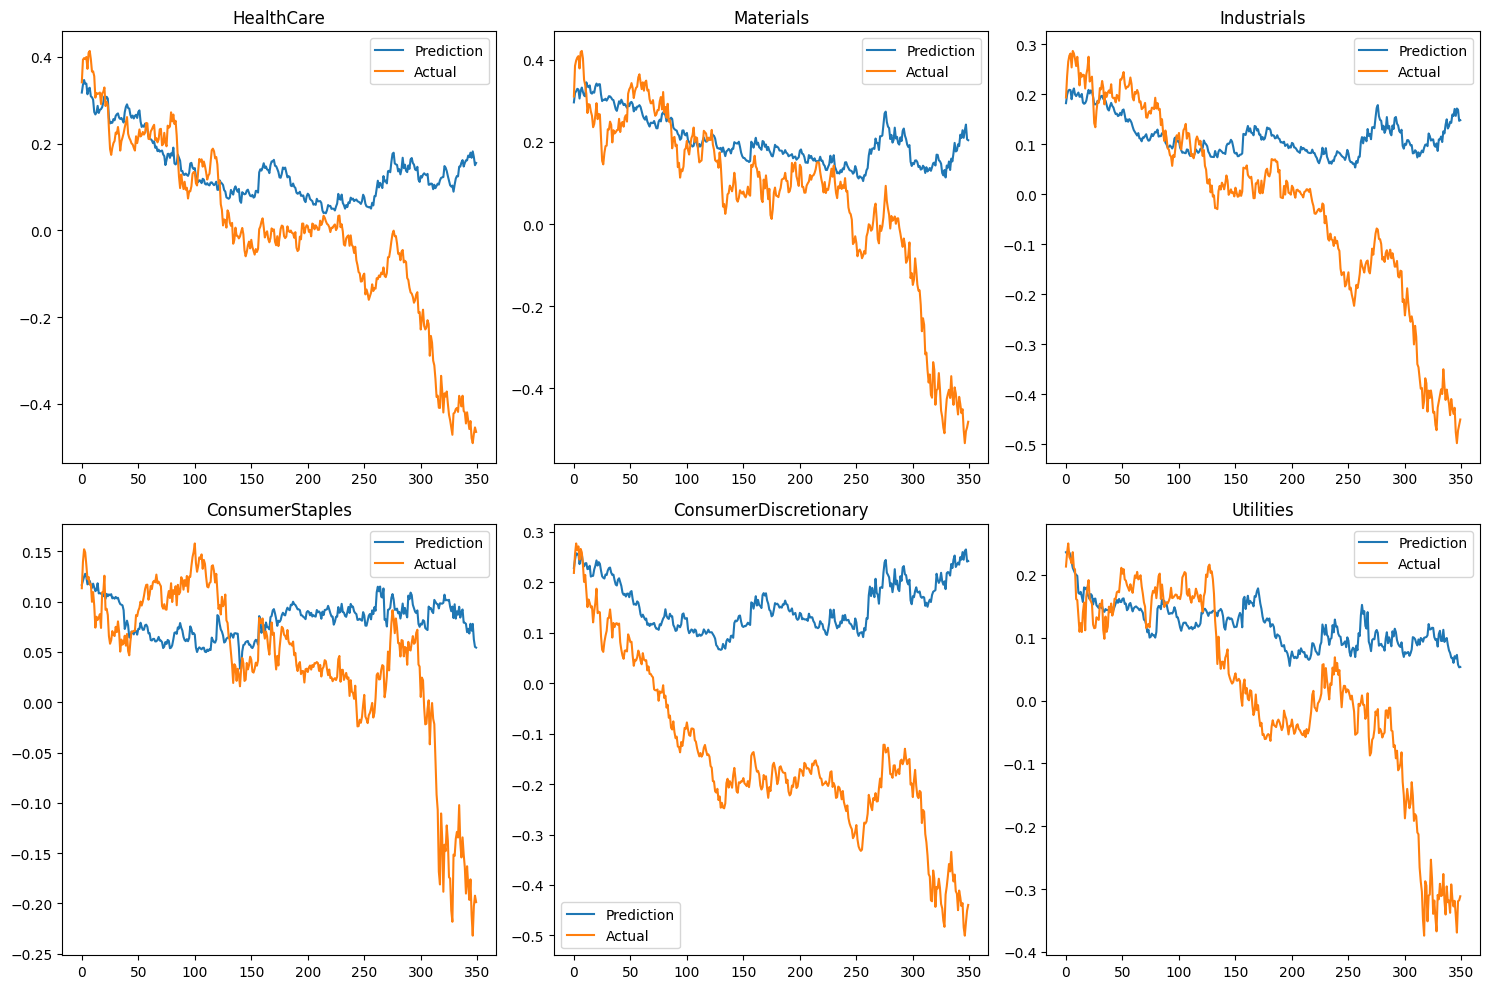

R² Scores for Each Sector:
HealthCare: -0.1906
Materials: -0.1402
Industrials: -0.3636
ConsumerStaples: -0.3985
ConsumerDiscretionary: -3.4677
Utilities: -0.2025
Window 1



Step 0.0/5.0, Loss: 0.119959
Step 1.0/5.0, Loss: 0.041236
Step 2.0/5.0, Loss: 0.033780
Step 3.0/5.0, Loss: 0.031266
Step 4.0/5.0, Loss: 0.029639
Step 4.999/5.0, Loss: 0.028259


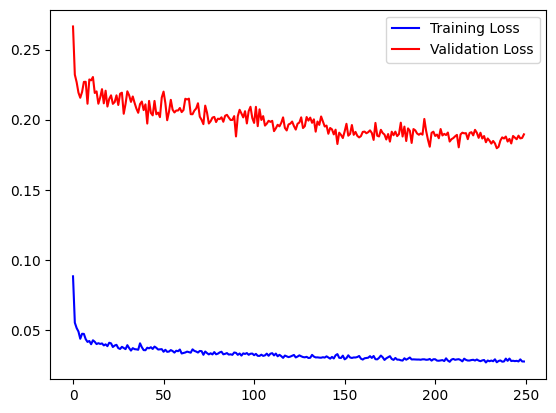

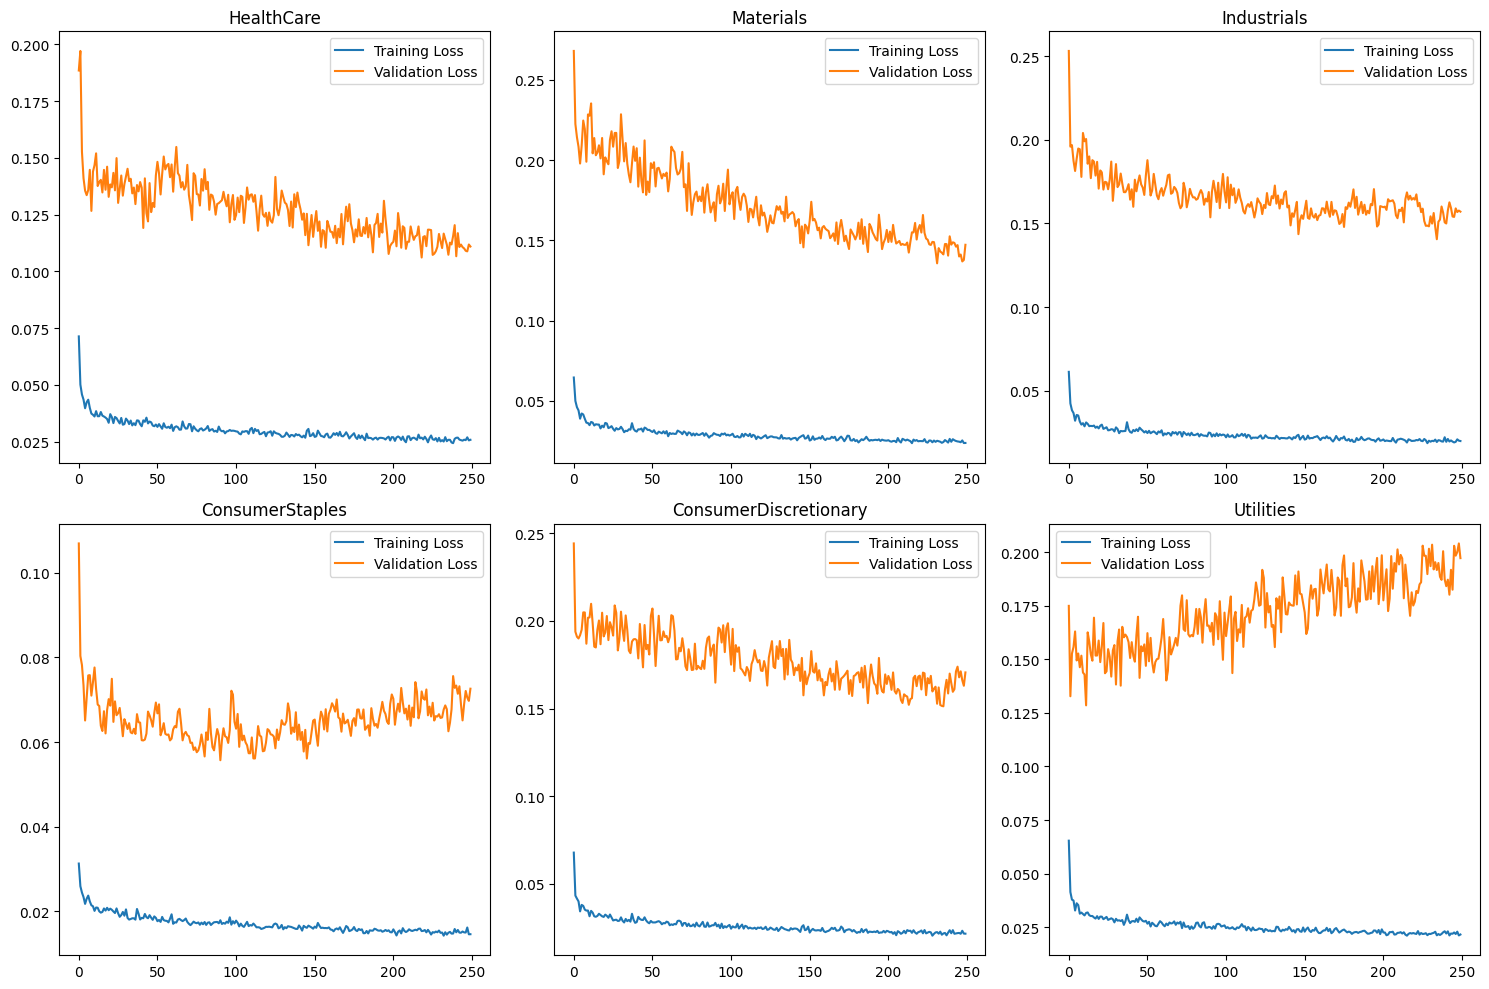

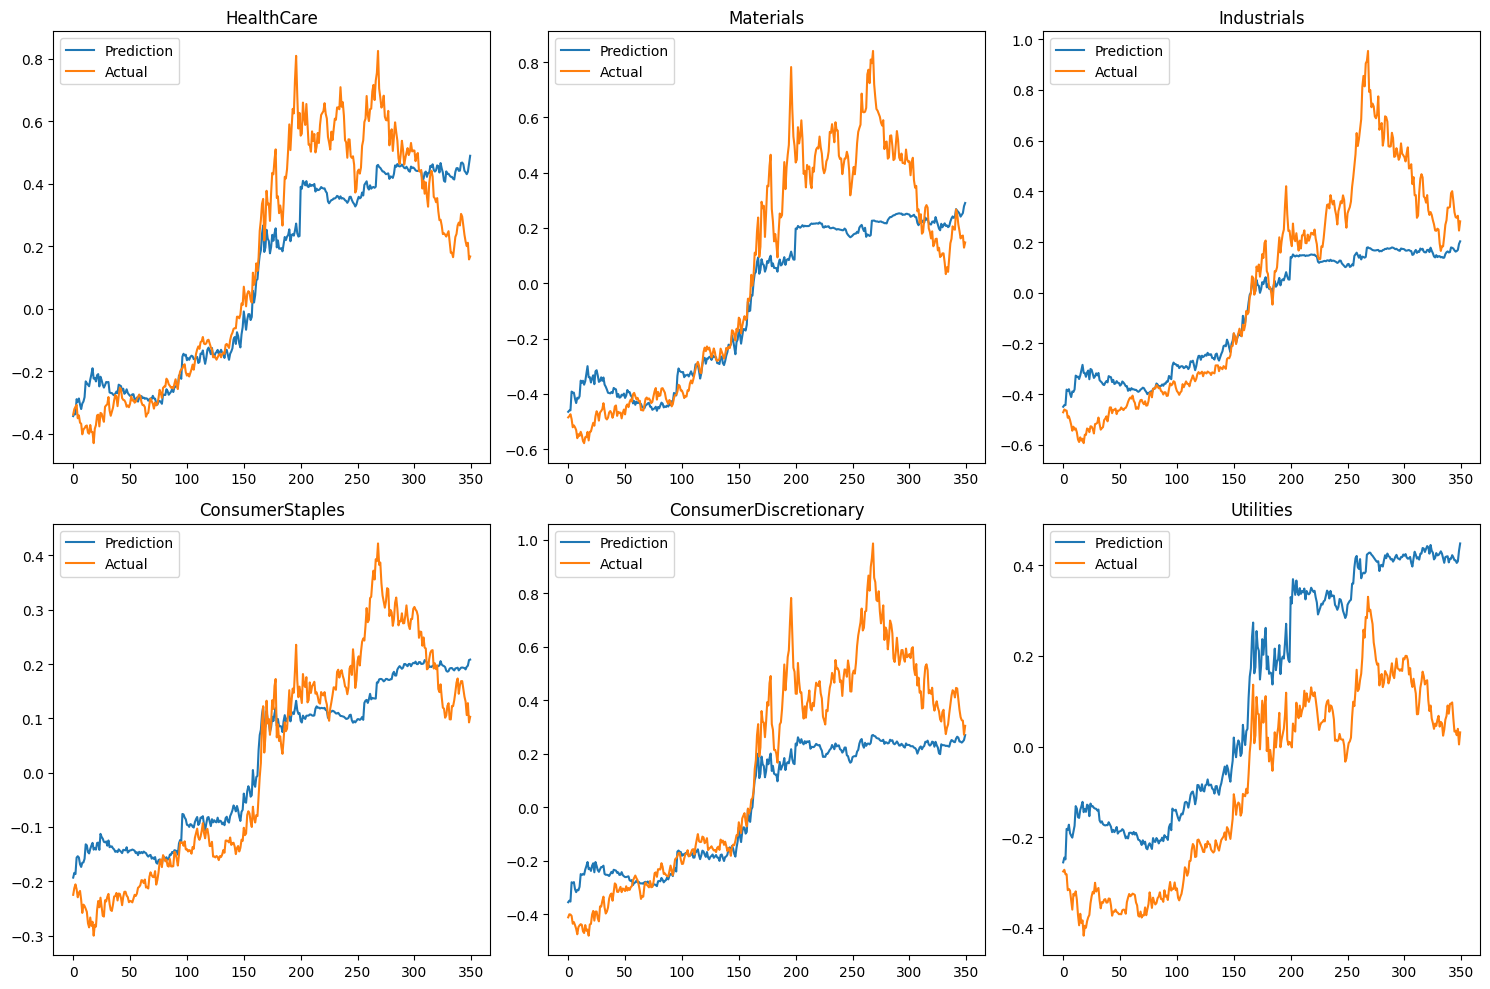

R² Scores for Each Sector:
HealthCare: 0.8351
Materials: 0.7549
Industrials: 0.6993
ConsumerStaples: 0.8322
ConsumerDiscretionary: 0.6604
Utilities: -0.1289
Window 2



Step 0.0/5.0, Loss: 0.119085
Step 1.0/5.0, Loss: 0.041328
Step 2.0/5.0, Loss: 0.035932
Step 3.0/5.0, Loss: 0.033945
Step 4.0/5.0, Loss: 0.032368
Step 4.999/5.0, Loss: 0.031254


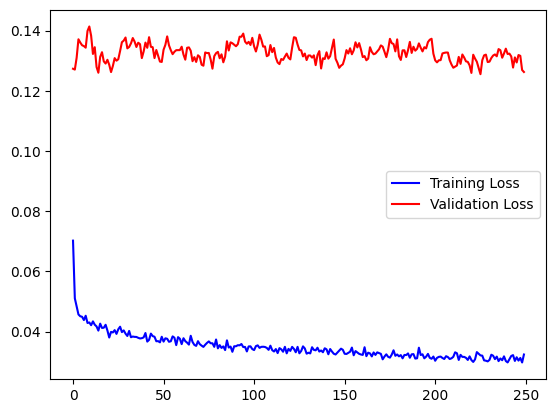

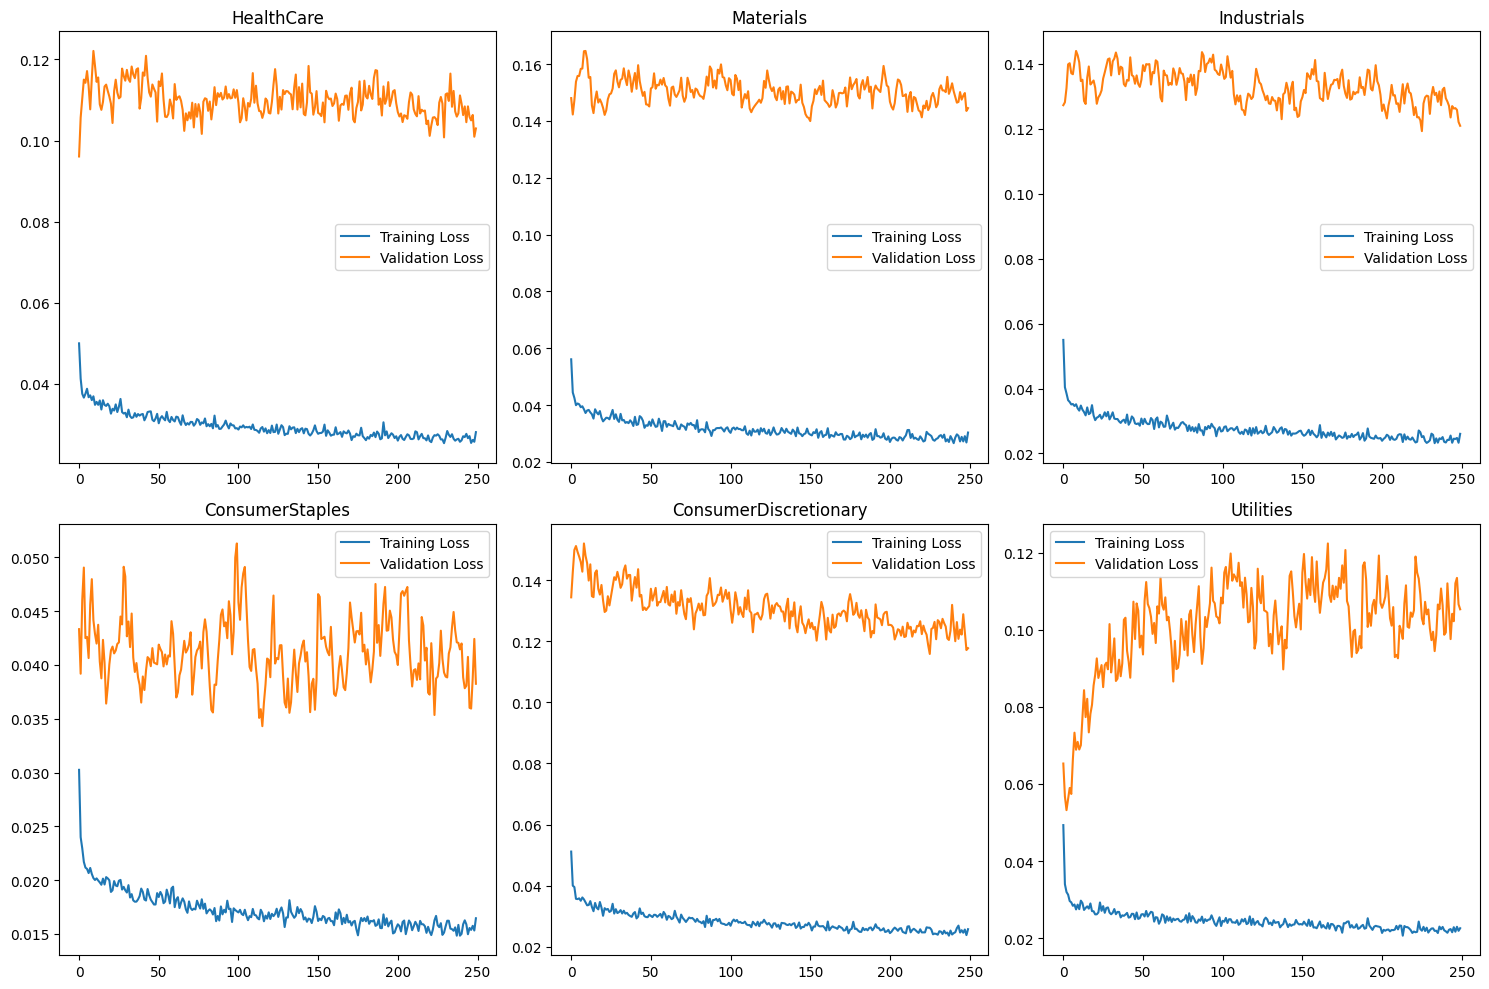

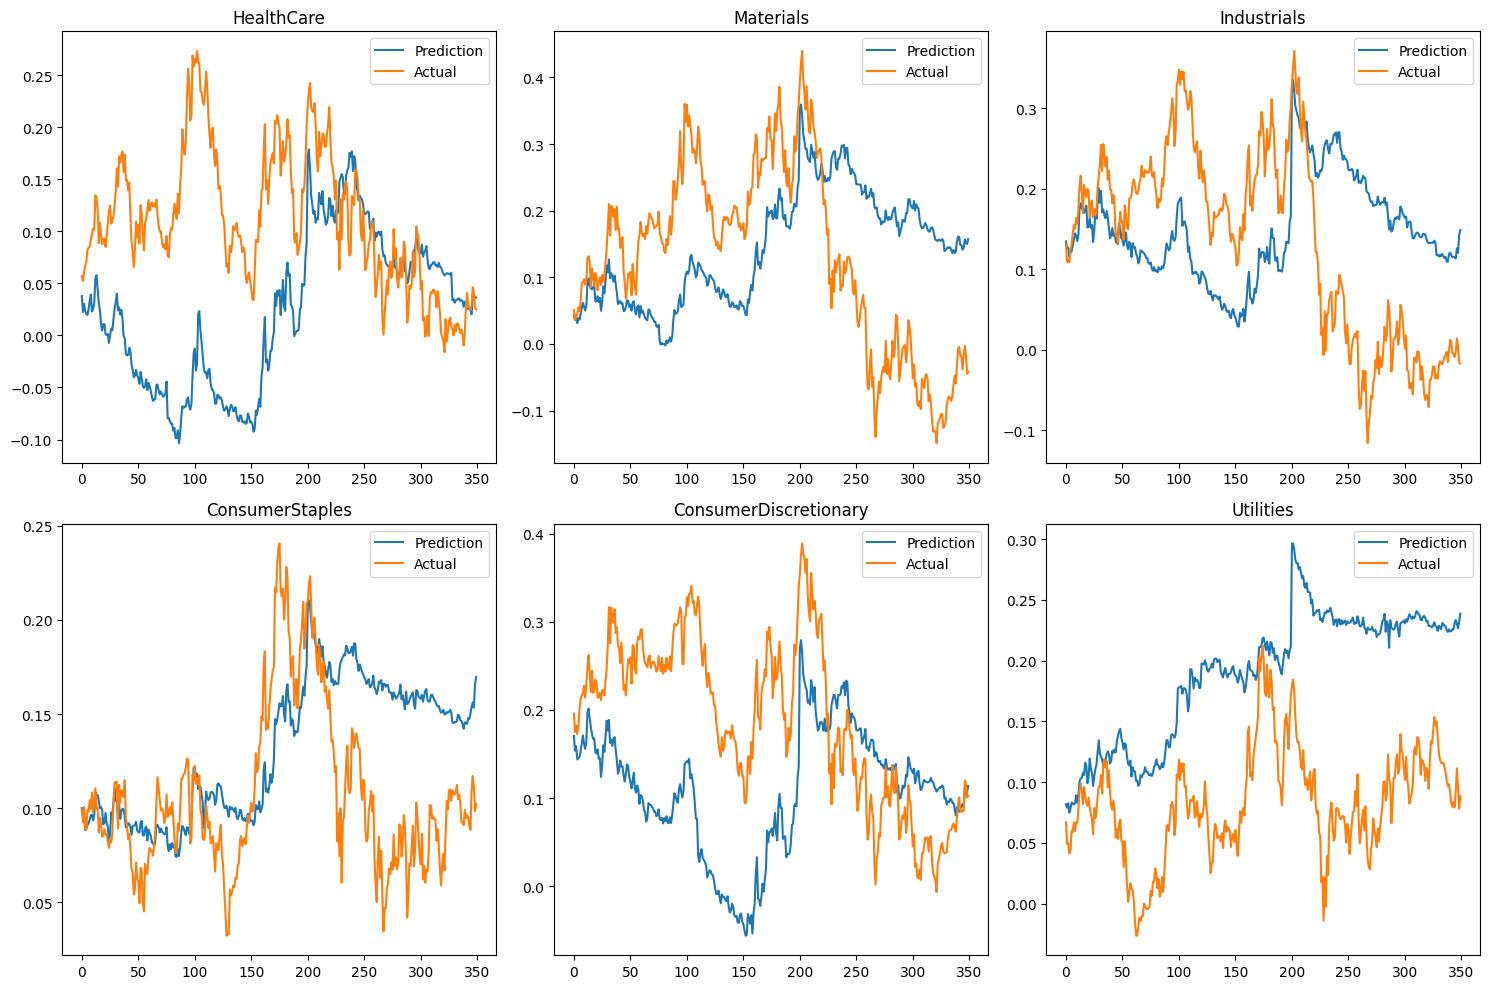

R² Scores for Each Sector:
HealthCare: -3.1606
Materials: -0.4121
Industrials: -0.4173
ConsumerStaples: -0.3871
ConsumerDiscretionary: -1.1561
Utilities: -6.0788
Window 3



Step 0.0/5.0, Loss: 0.076233
Step 1.0/5.0, Loss: 0.036858
Step 2.0/5.0, Loss: 0.033126
Step 3.0/5.0, Loss: 0.031606
Step 4.0/5.0, Loss: 0.030390
Step 4.999/5.0, Loss: 0.029660


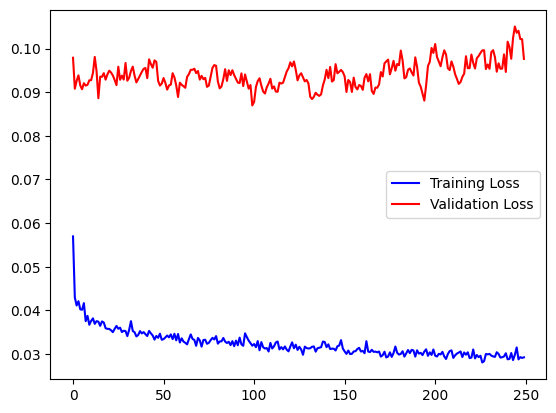

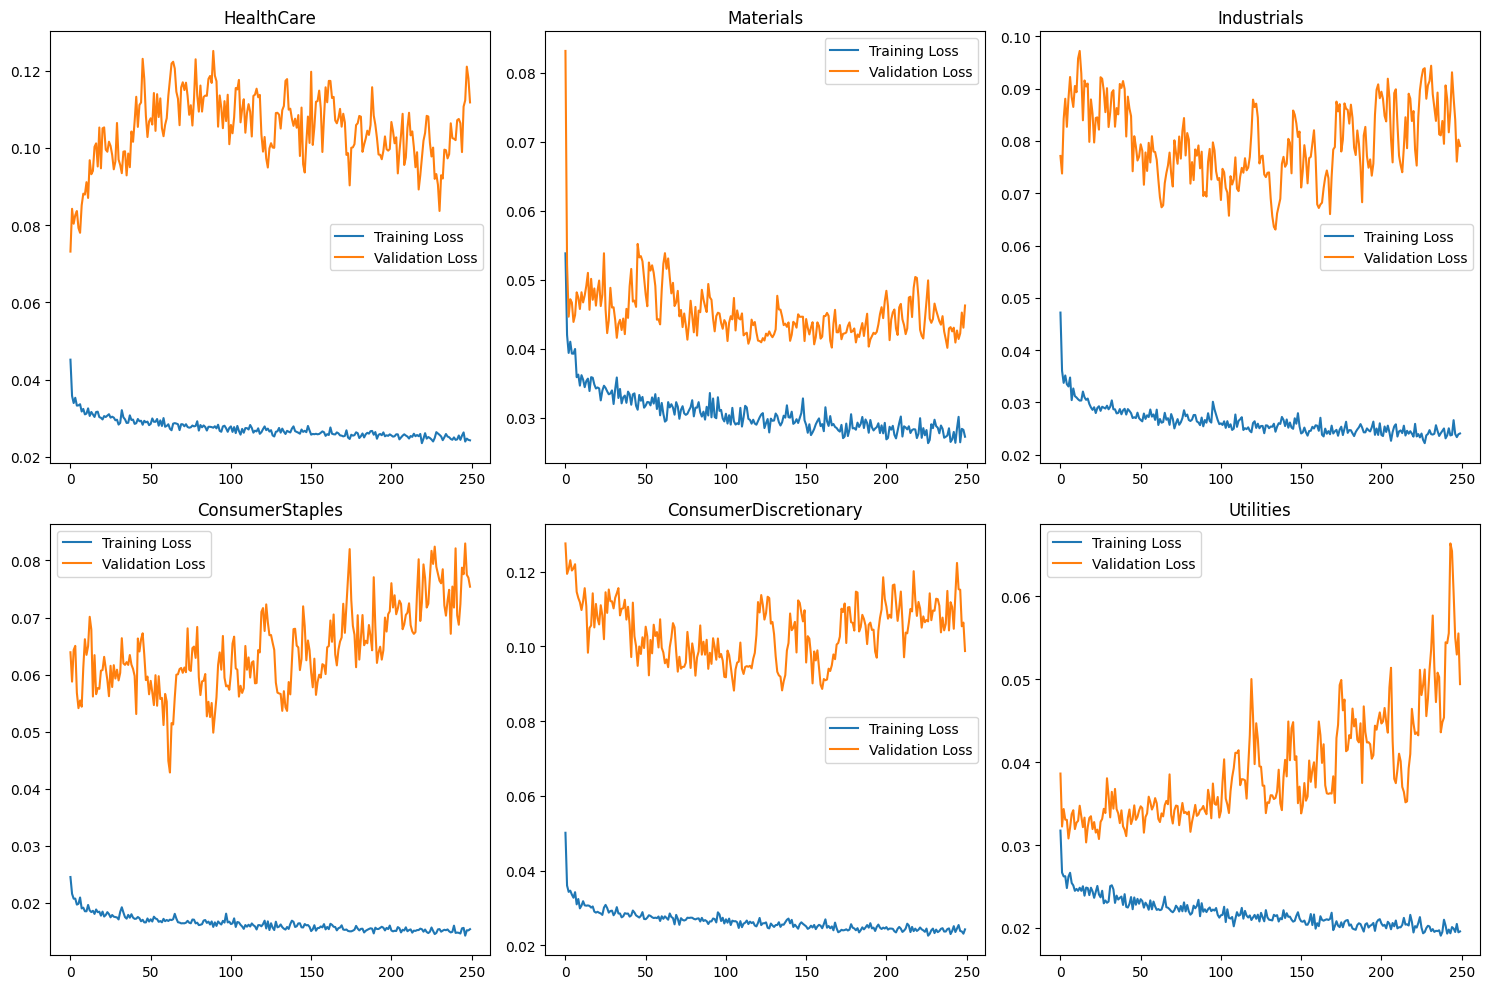

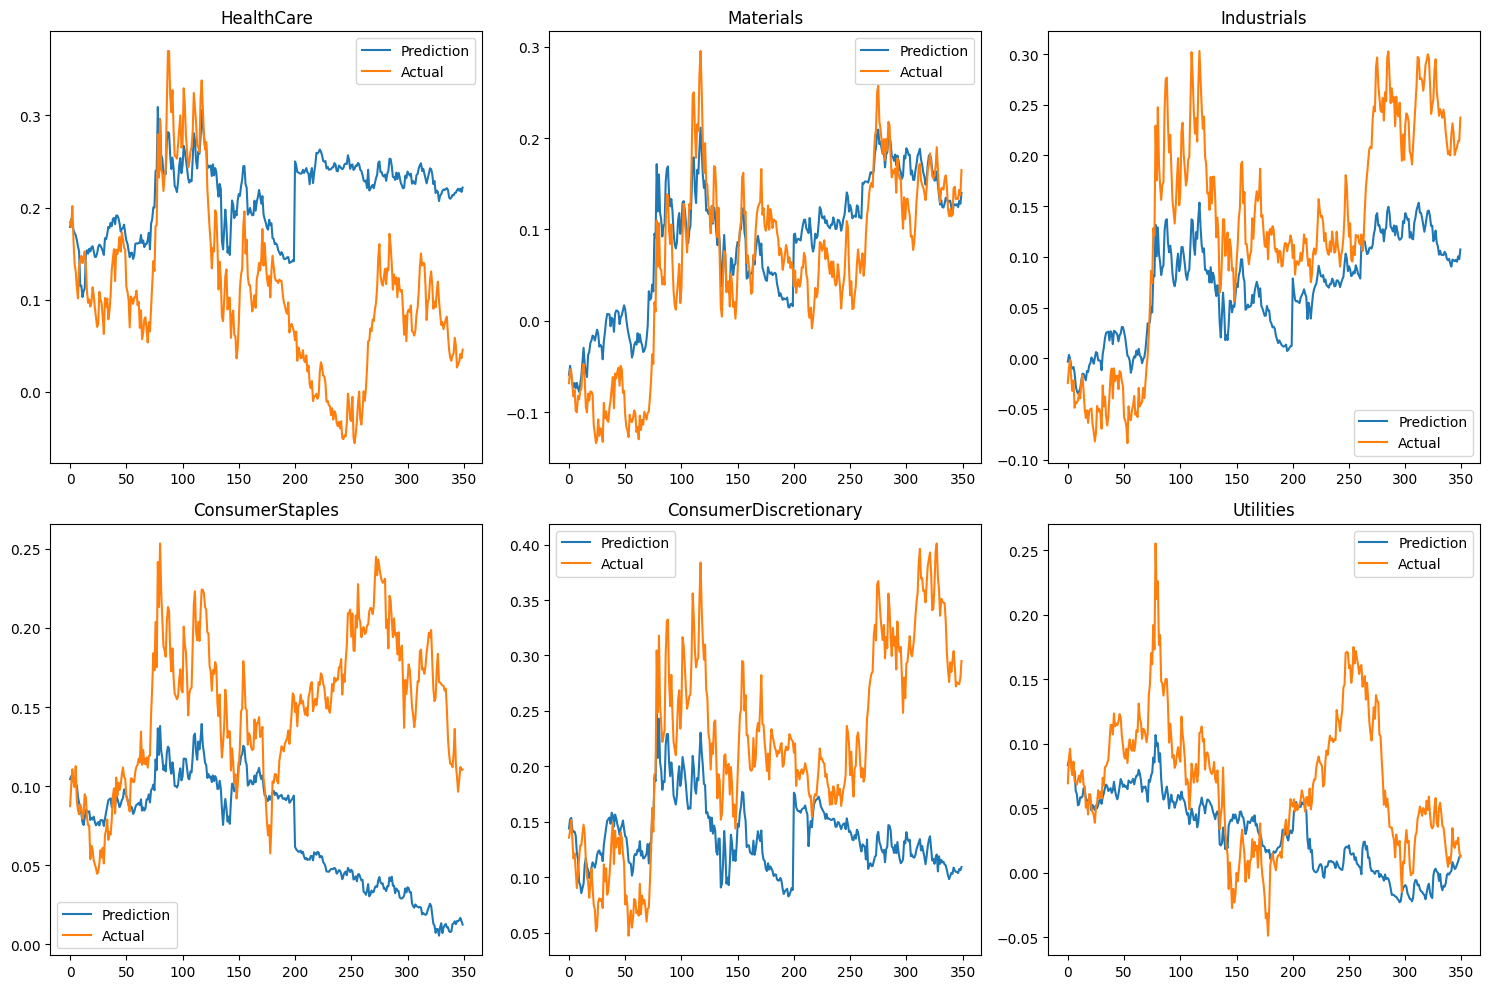

R² Scores for Each Sector:
HealthCare: -1.5055
Materials: 0.6781
Industrials: 0.3205
ConsumerStaples: -3.7332
ConsumerDiscretionary: -0.9393
Utilities: -0.5163
Window 4



Step 0.0/5.0, Loss: 0.063549
Step 1.0/5.0, Loss: 0.032598
Step 2.0/5.0, Loss: 0.029625
Step 3.0/5.0, Loss: 0.028446
Step 4.0/5.0, Loss: 0.027576
Step 4.999/5.0, Loss: 0.026751


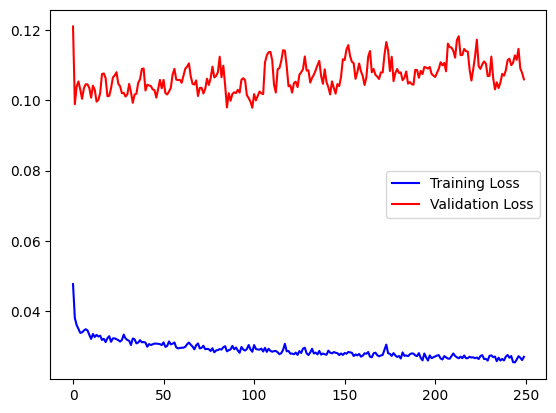

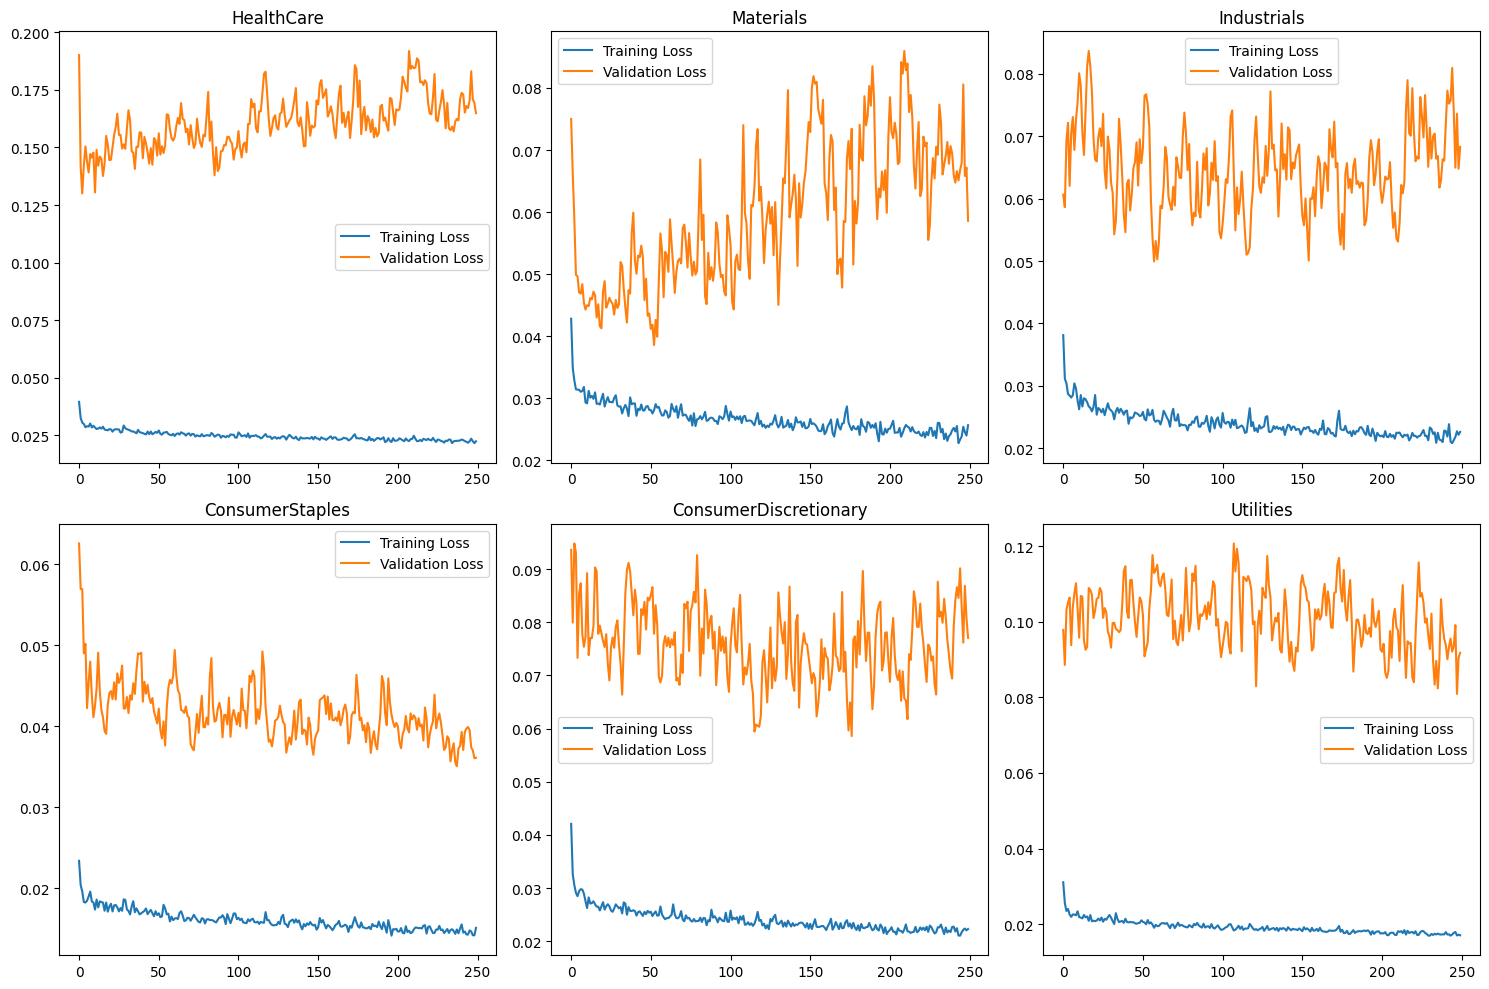

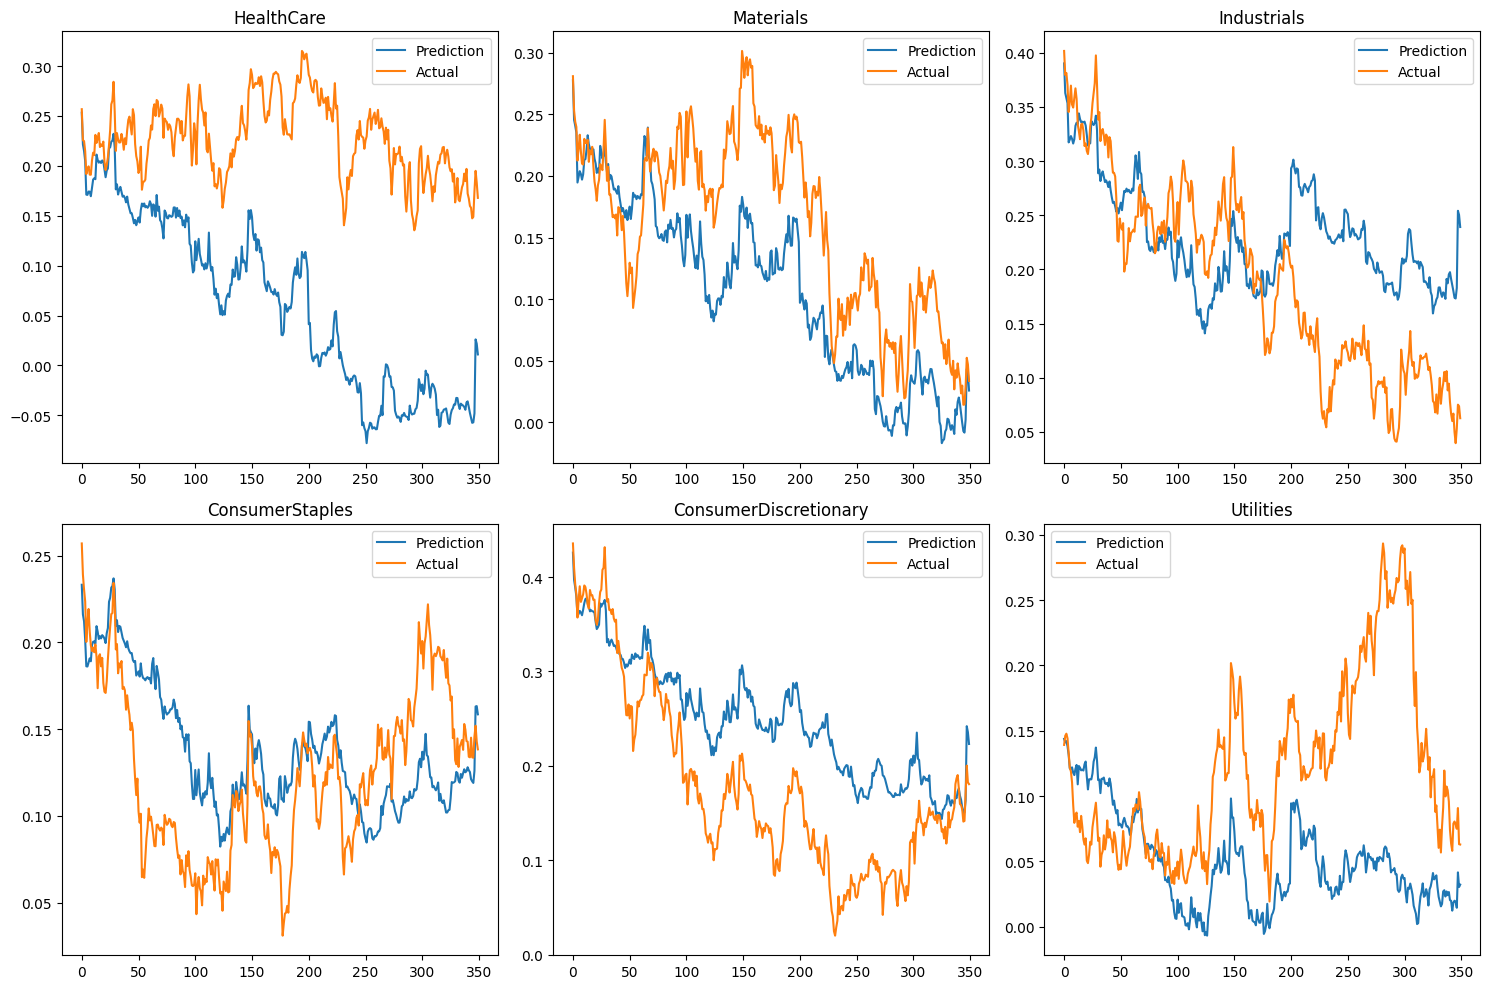

R² Scores for Each Sector:
HealthCare: -22.2563
Materials: 0.0357
Industrials: 0.1181
ConsumerStaples: -0.0169
ConsumerDiscretionary: 0.1982
Utilities: -1.4017
Window 5



Step 0.0/5.0, Loss: 0.107113
Step 1.0/5.0, Loss: 0.030371
Step 2.0/5.0, Loss: 0.026287
Step 3.0/5.0, Loss: 0.024774
Step 4.0/5.0, Loss: 0.024000
Step 4.999/5.0, Loss: 0.023195


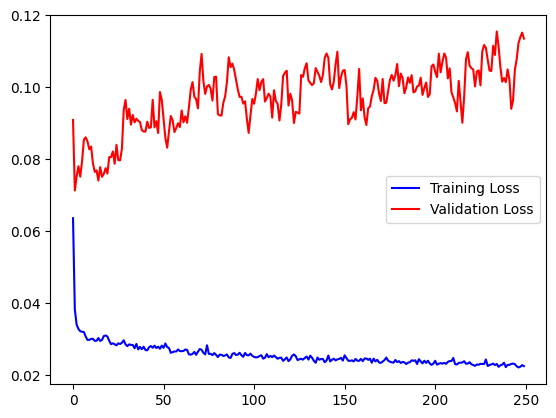

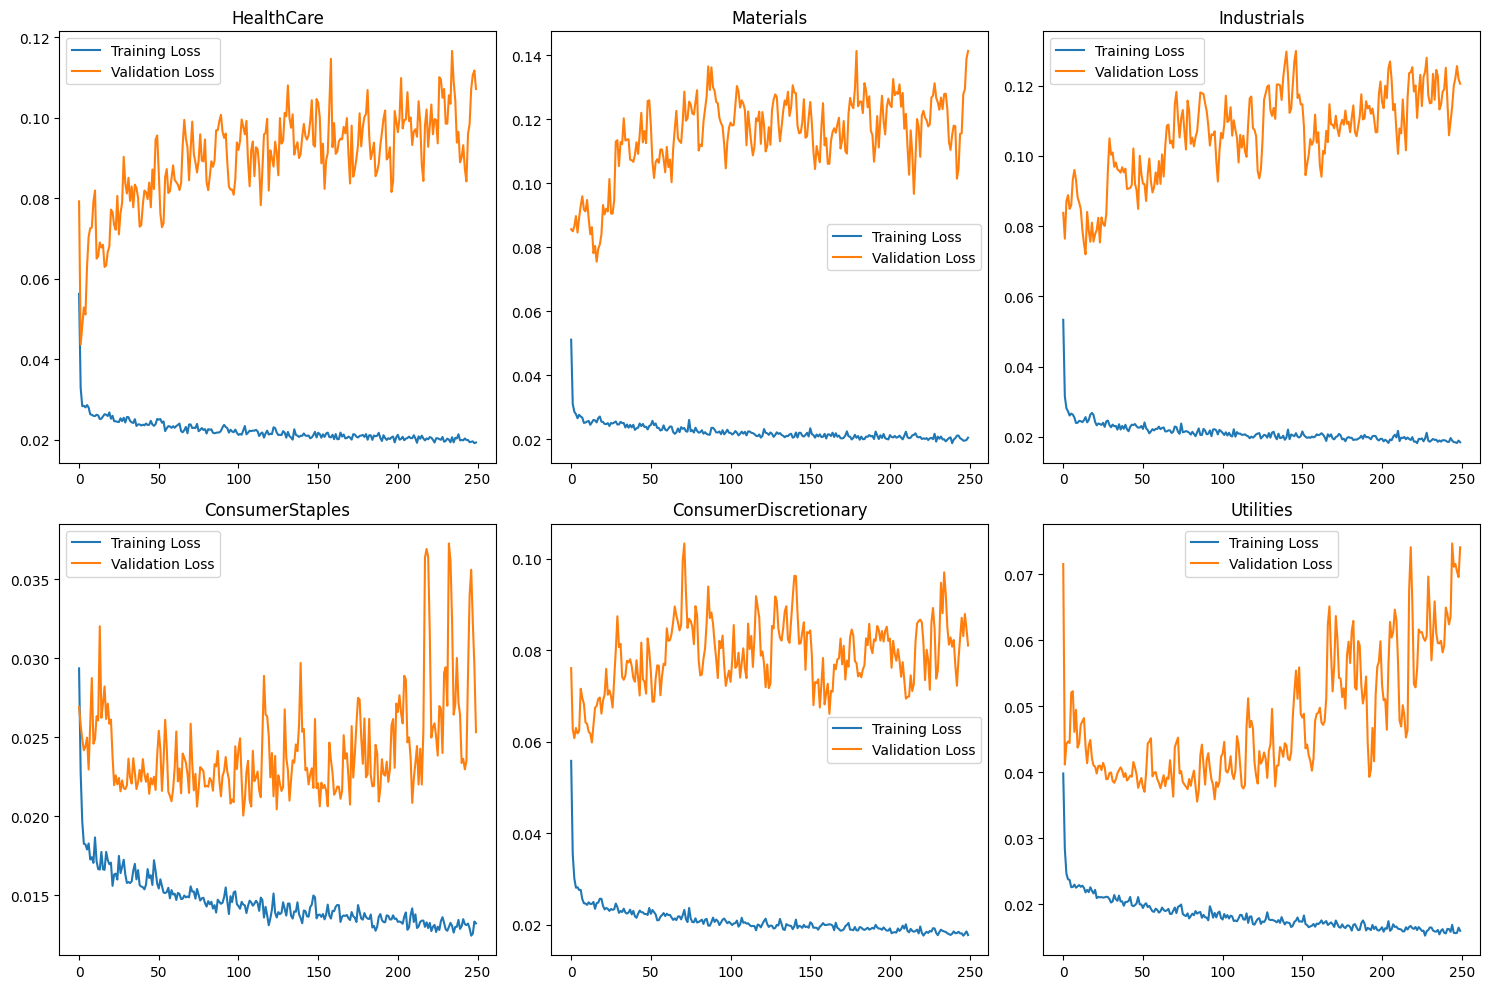

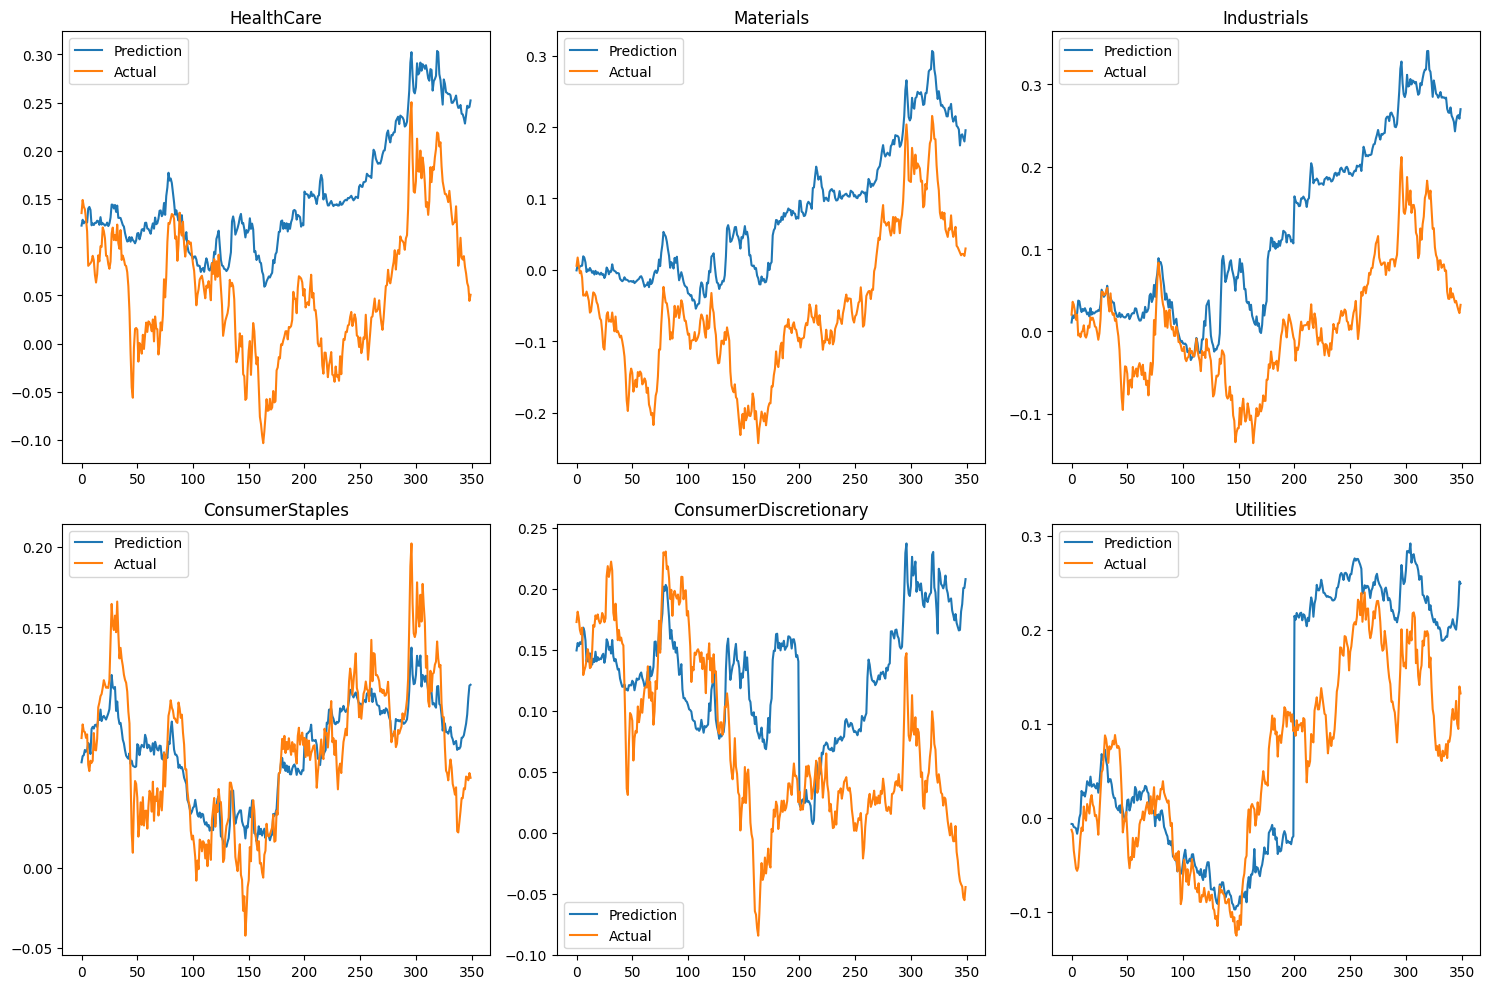

R² Scores for Each Sector:
HealthCare: -1.7901
Materials: -1.1178
Industrials: -2.7705
ConsumerStaples: 0.6788
ConsumerDiscretionary: -0.8066
Utilities: 0.3639
Window 6



Step 0.0/5.0, Loss: 0.071698
Step 1.0/5.0, Loss: 0.025670
Step 2.0/5.0, Loss: 0.022534
Step 3.0/5.0, Loss: 0.021236
Step 4.0/5.0, Loss: 0.020393
Step 4.999/5.0, Loss: 0.019686


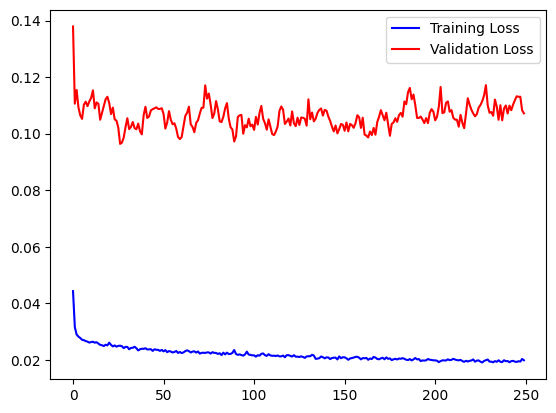

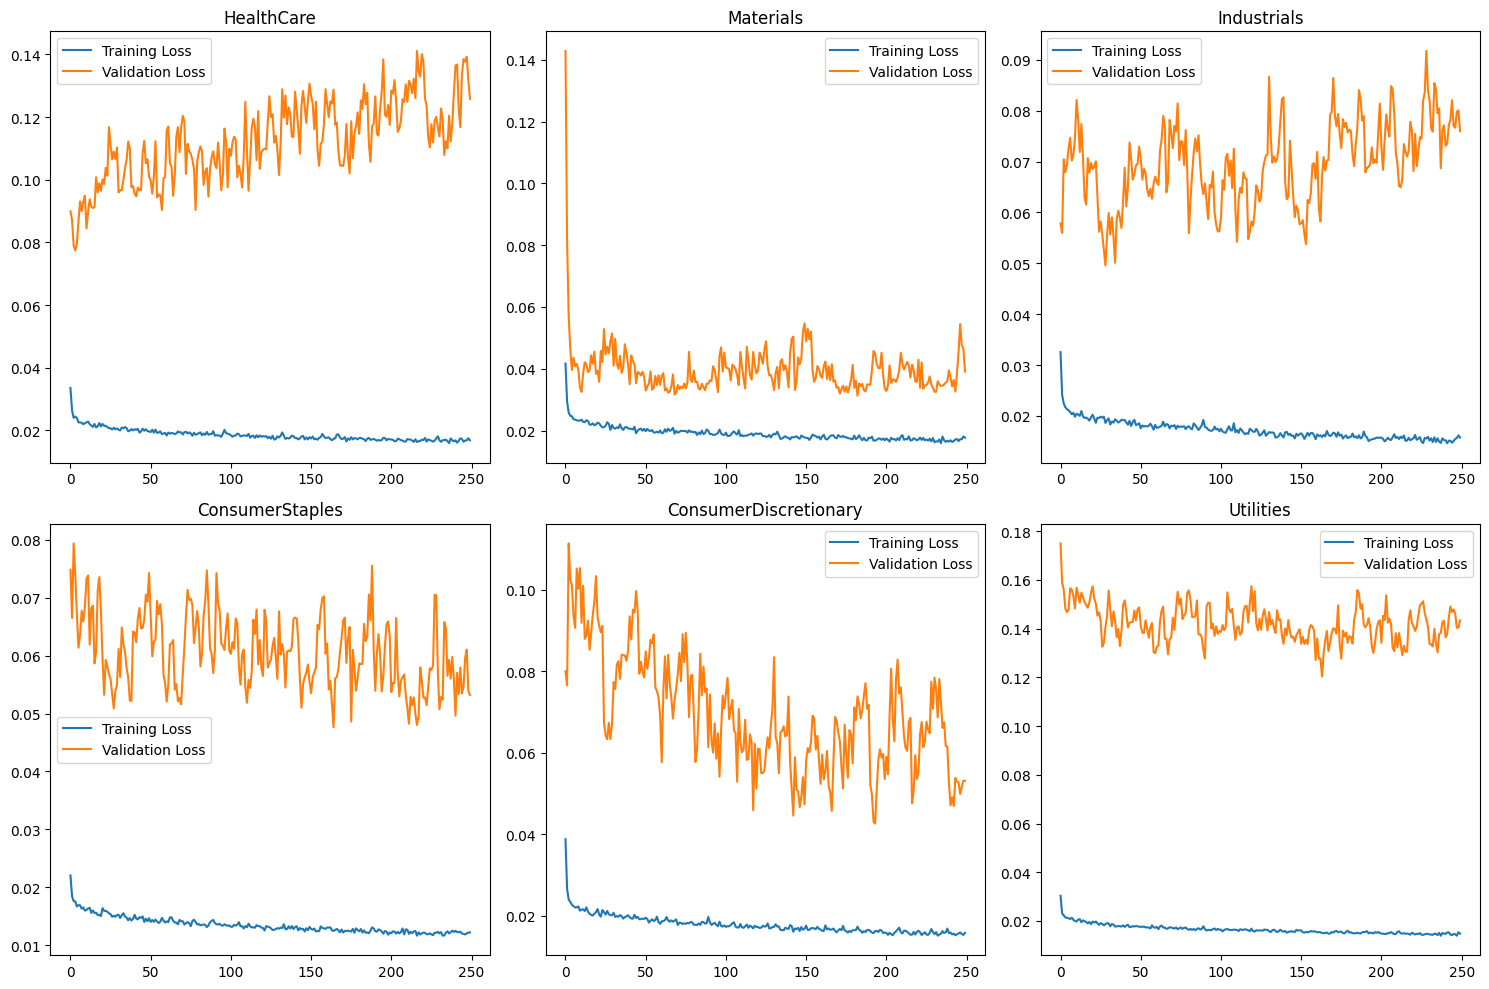

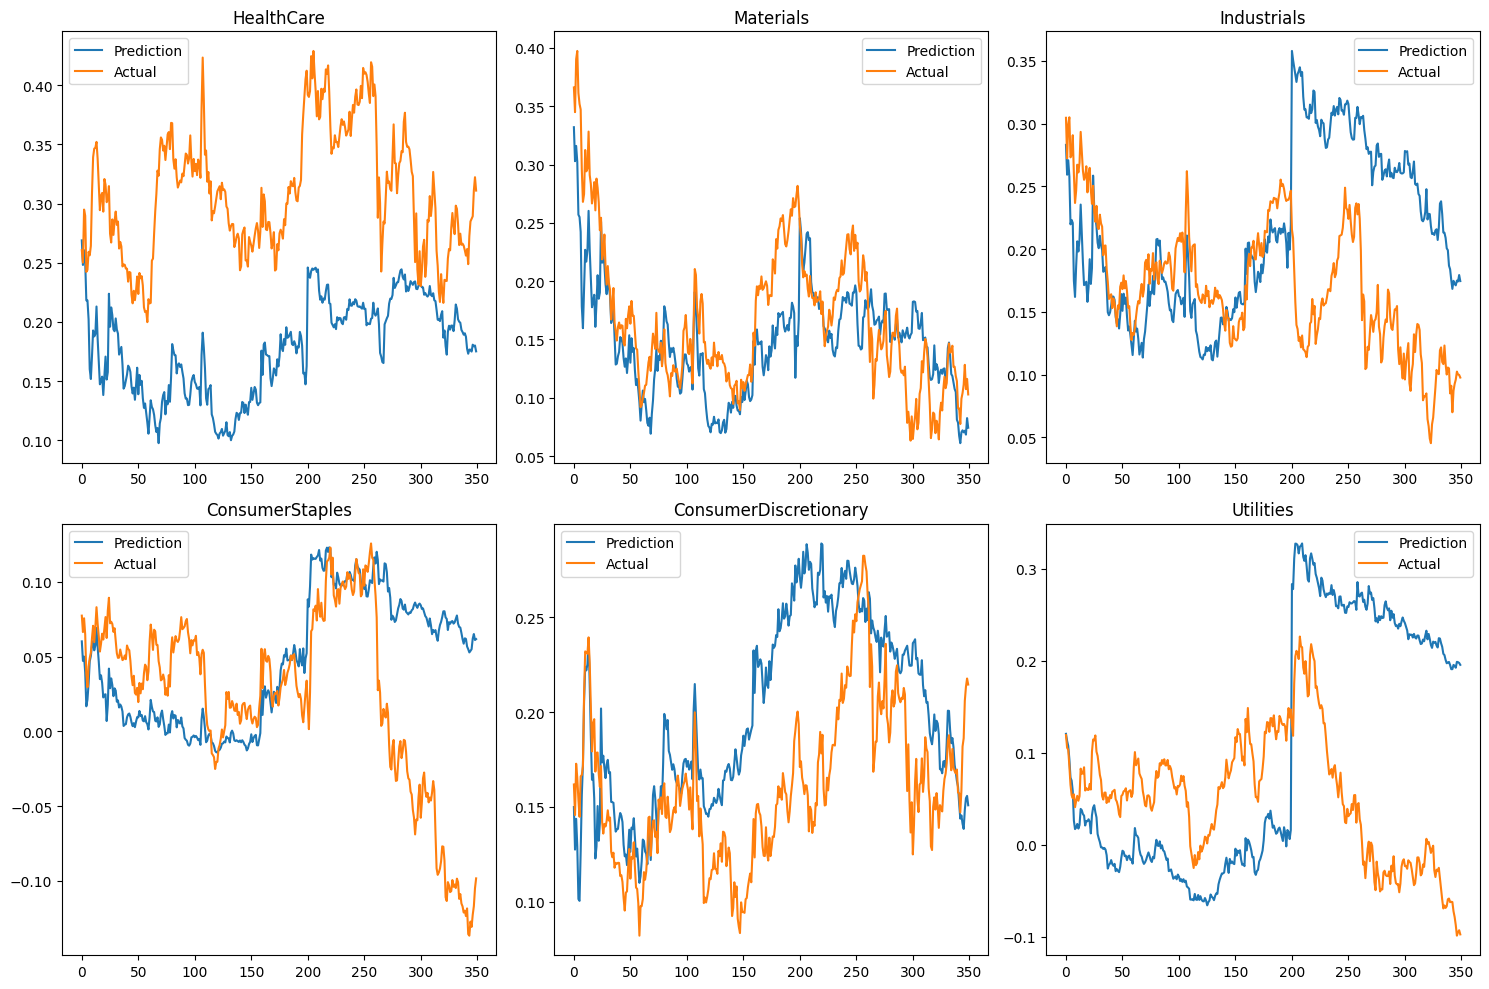

R² Scores for Each Sector:
HealthCare: -6.3364
Materials: 0.4058
Industrials: -2.3181
ConsumerStaples: -0.5779
ConsumerDiscretionary: -0.9993
Utilities: -4.9595
Window 7



Step 0.0/5.0, Loss: 0.057784
Step 1.0/5.0, Loss: 0.023395
Step 2.0/5.0, Loss: 0.020342
Step 3.0/5.0, Loss: 0.019053
Step 4.0/5.0, Loss: 0.018063
Step 4.999/5.0, Loss: 0.017304


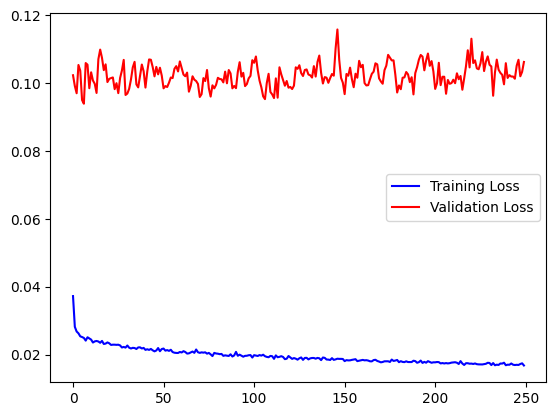

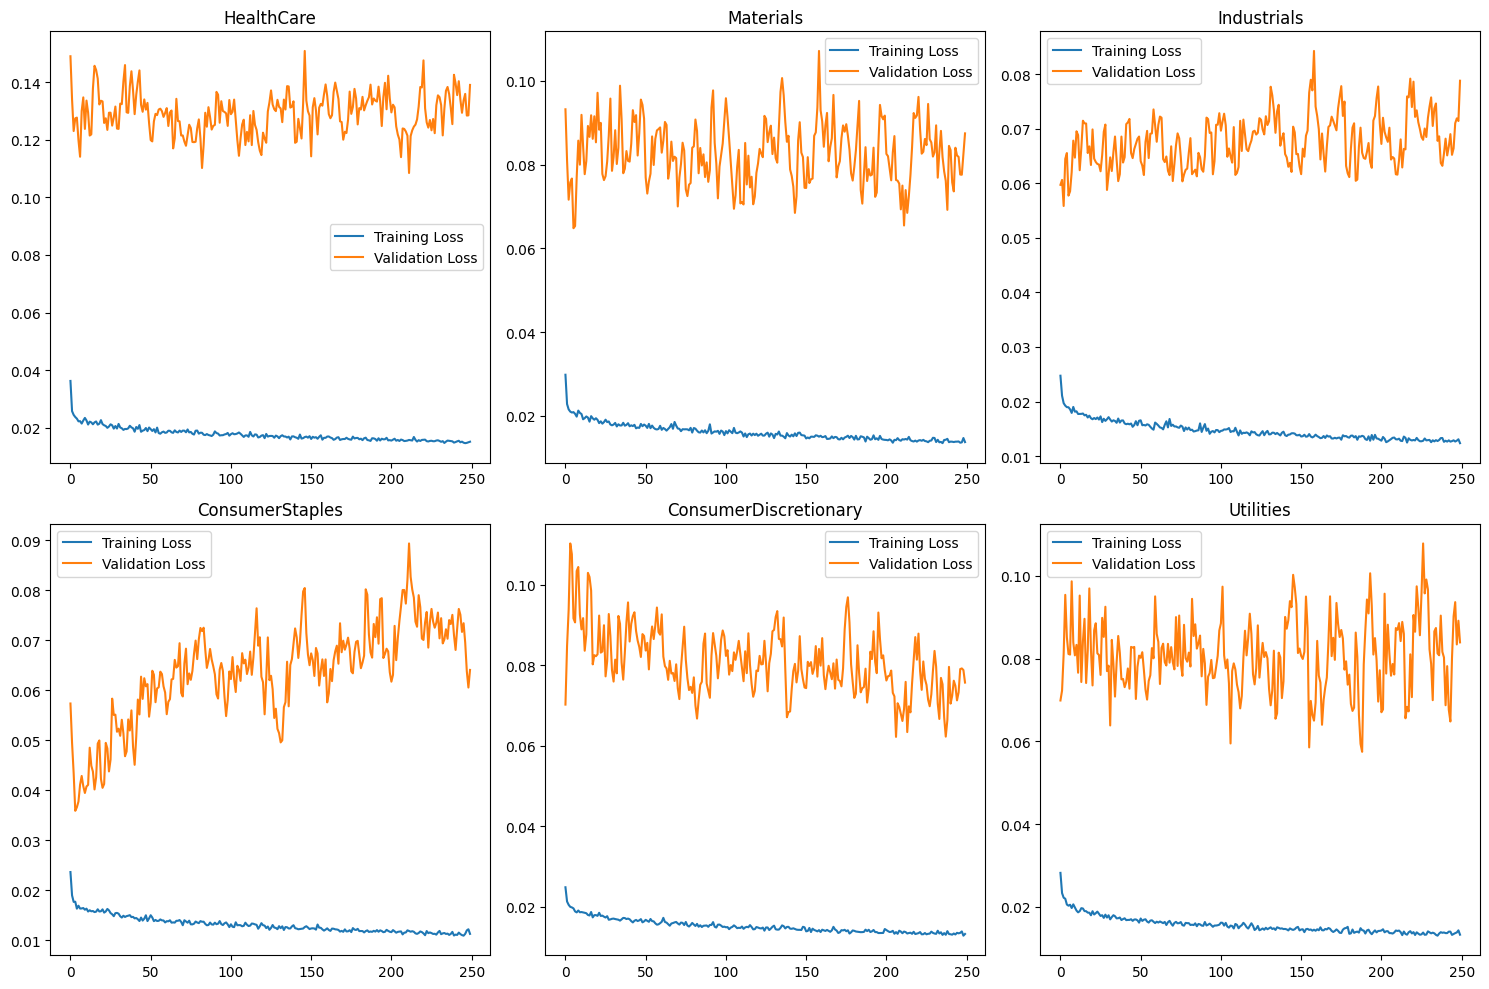

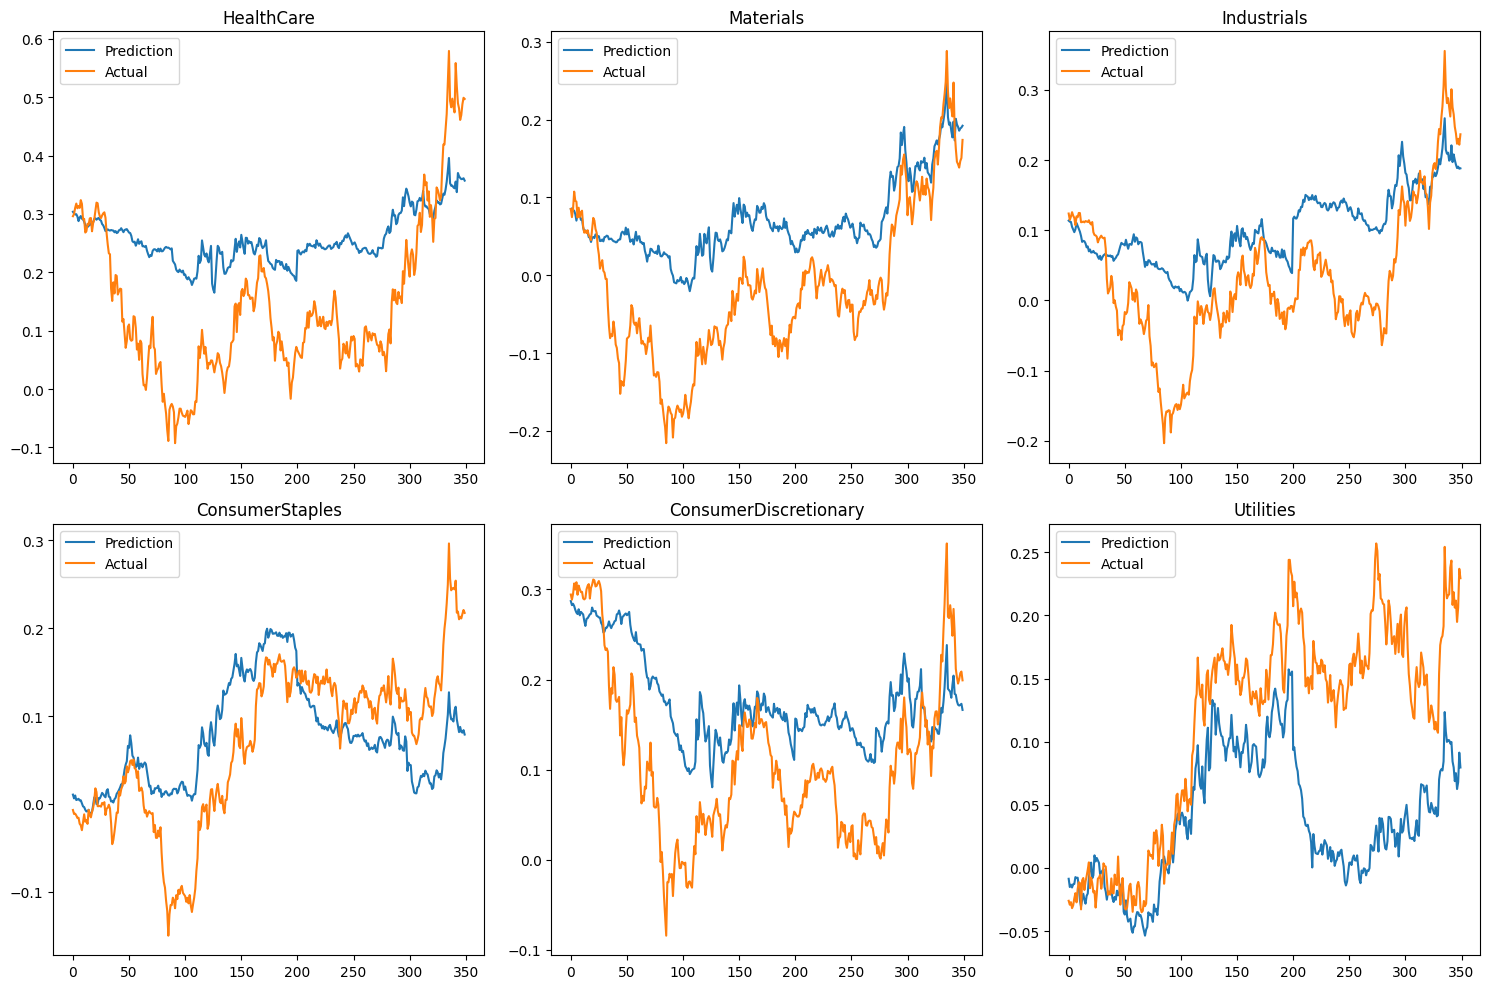

R² Scores for Each Sector:
HealthCare: -0.2774
Materials: -0.1515
Industrials: 0.0474
ConsumerStaples: 0.3503
ConsumerDiscretionary: -0.0077
Utilities: -0.3634
Window 8



Step 0.0/5.0, Loss: 0.077097
Step 1.0/5.0, Loss: 0.025921
Step 2.0/5.0, Loss: 0.021955
Step 3.0/5.0, Loss: 0.020645
Step 4.0/5.0, Loss: 0.019673
Step 4.999/5.0, Loss: 0.018905


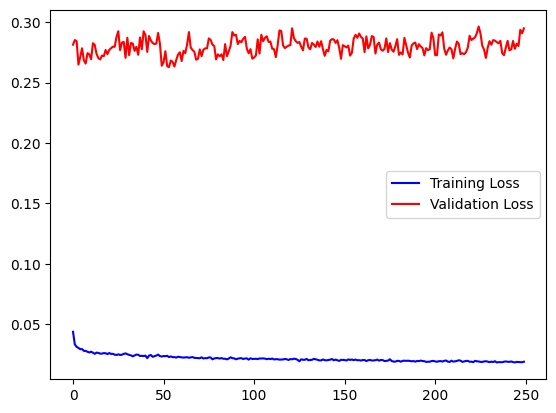

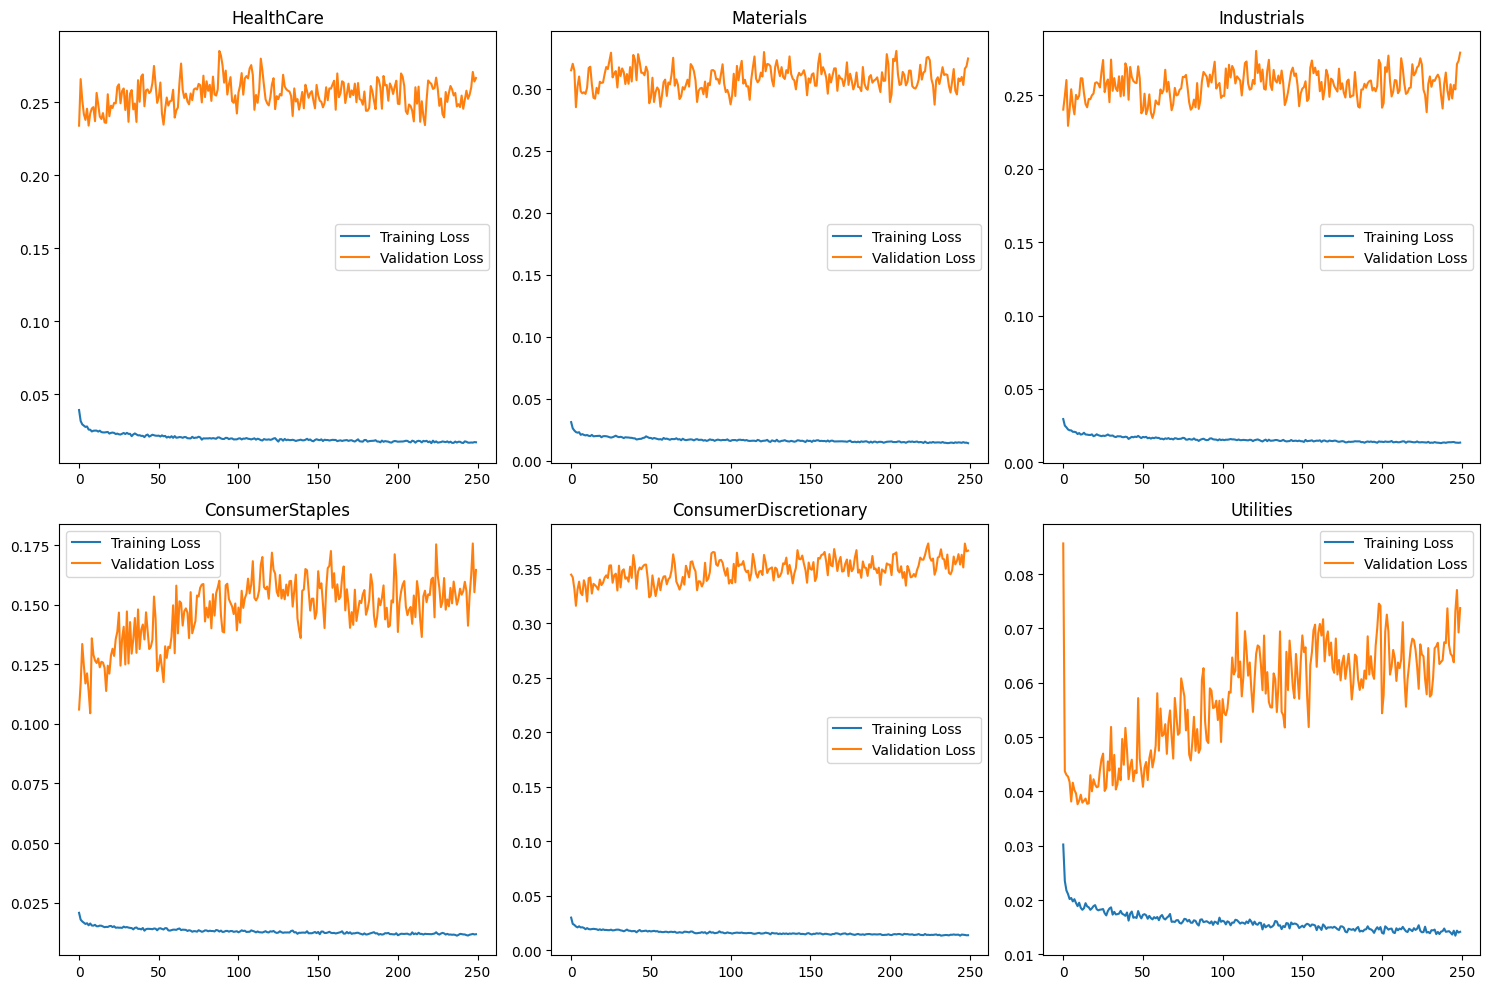

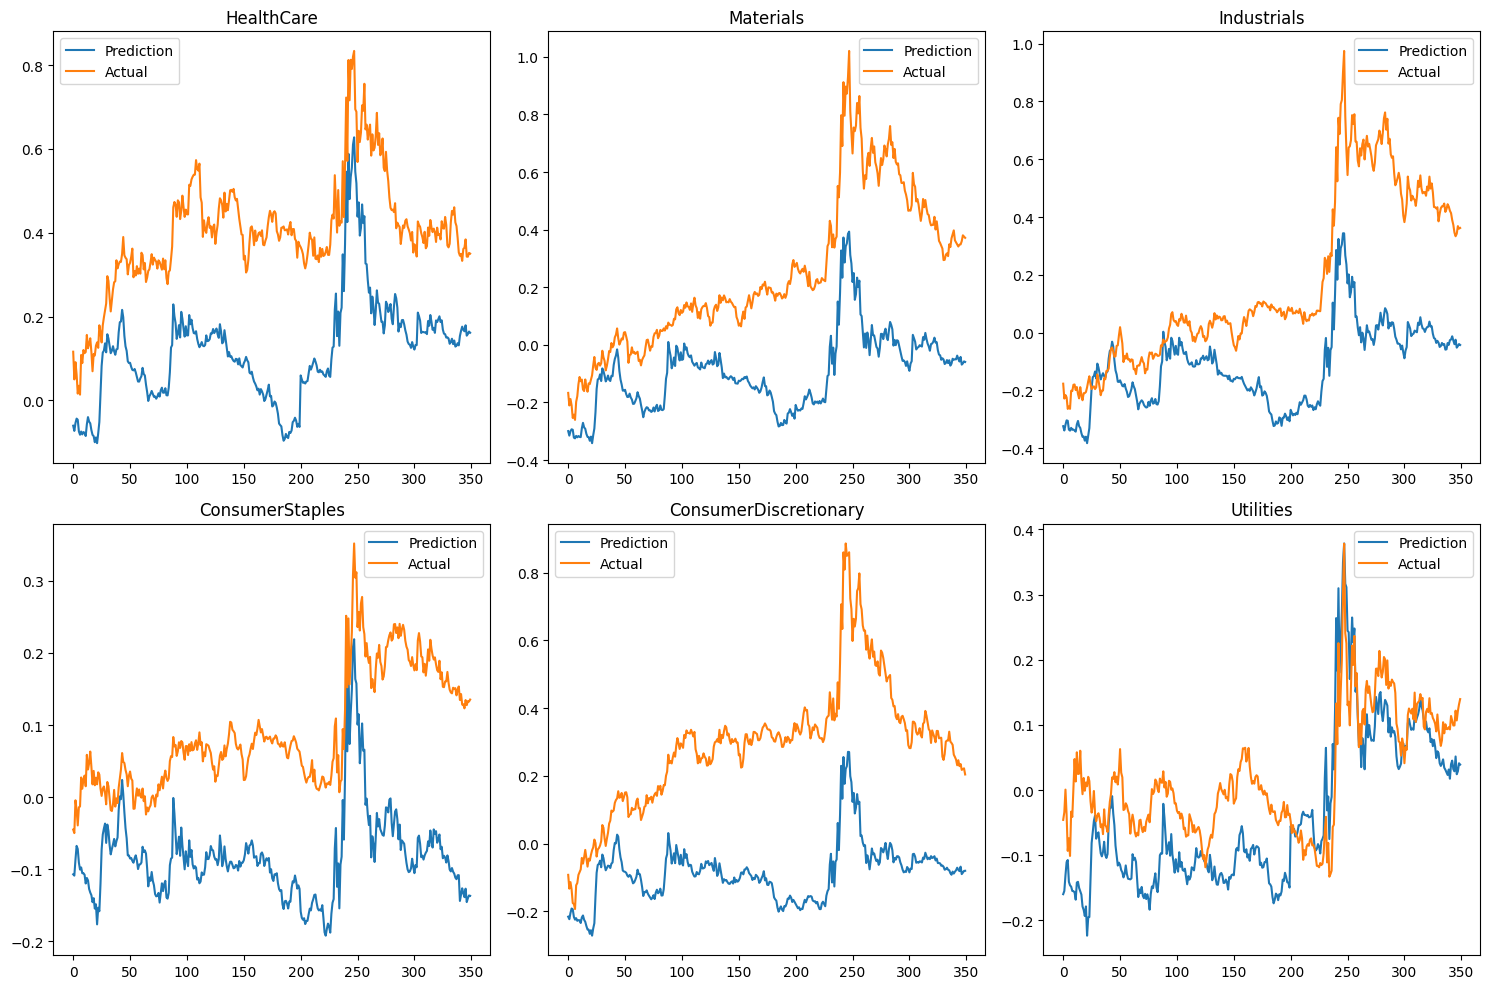

R² Scores for Each Sector:
HealthCare: -3.7795
Materials: -1.1117
Industrials: -0.4310
ConsumerStaples: -4.4816
ConsumerDiscretionary: -3.5856
Utilities: -0.0460
Window 9



Step 0.0/5.0, Loss: 0.130745
Step 1.0/5.0, Loss: 0.029837
Step 2.0/5.0, Loss: 0.024790
Step 3.0/5.0, Loss: 0.023077
Step 4.0/5.0, Loss: 0.022119
Step 4.999/5.0, Loss: 0.021023


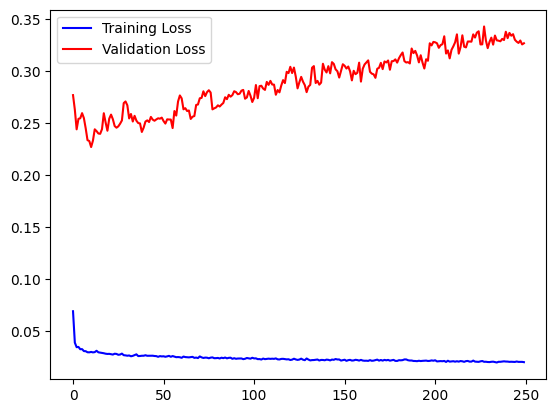

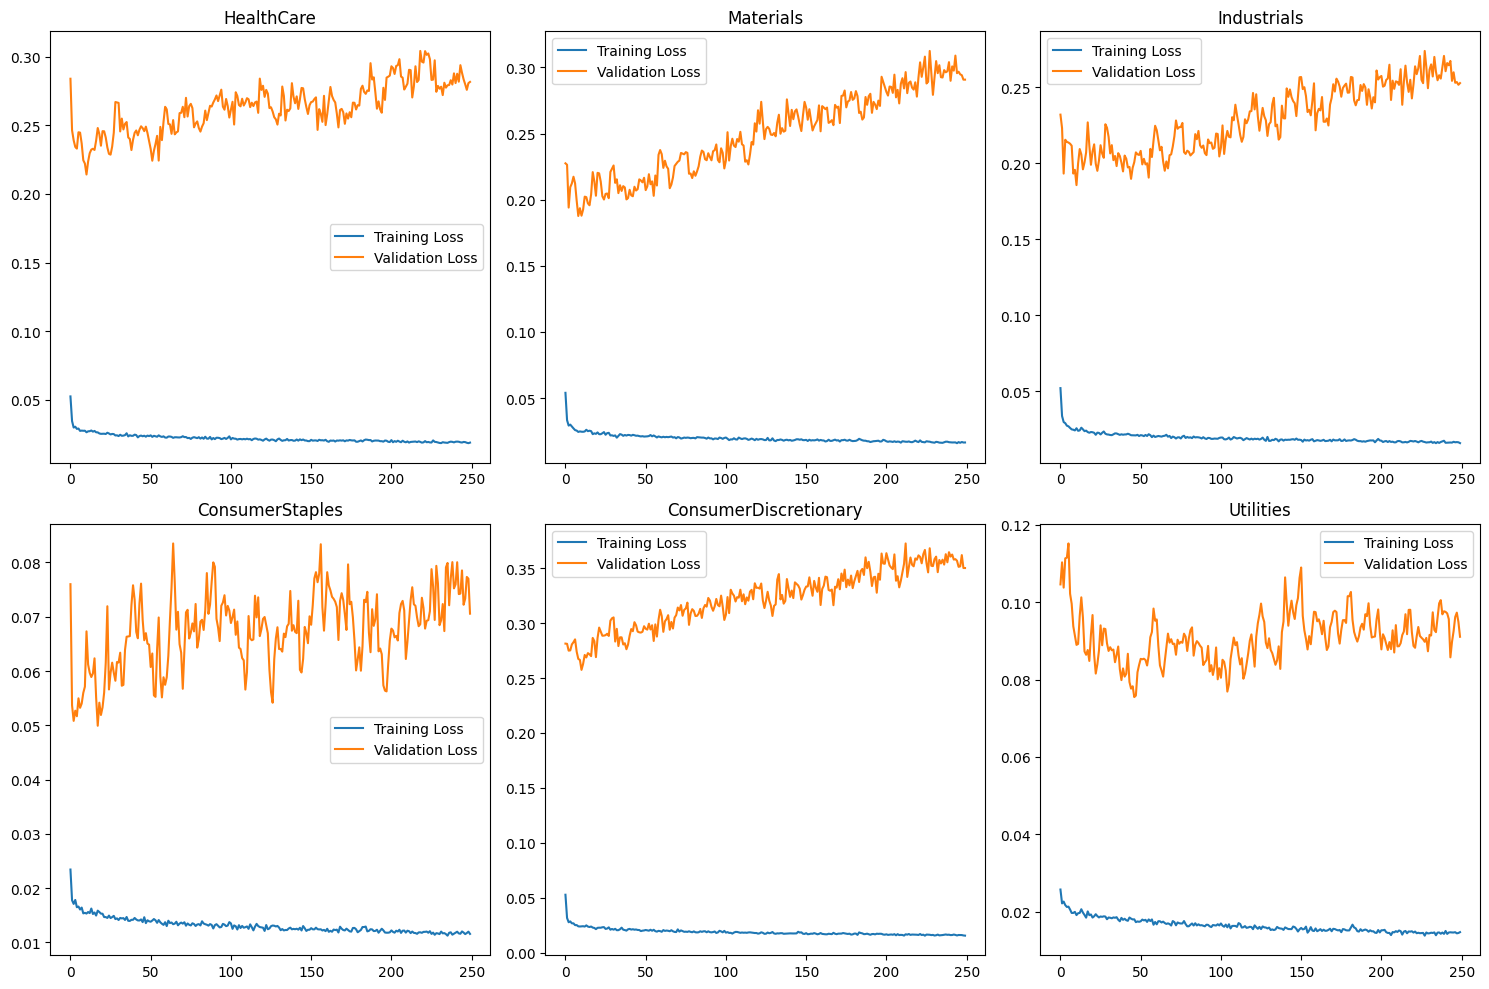

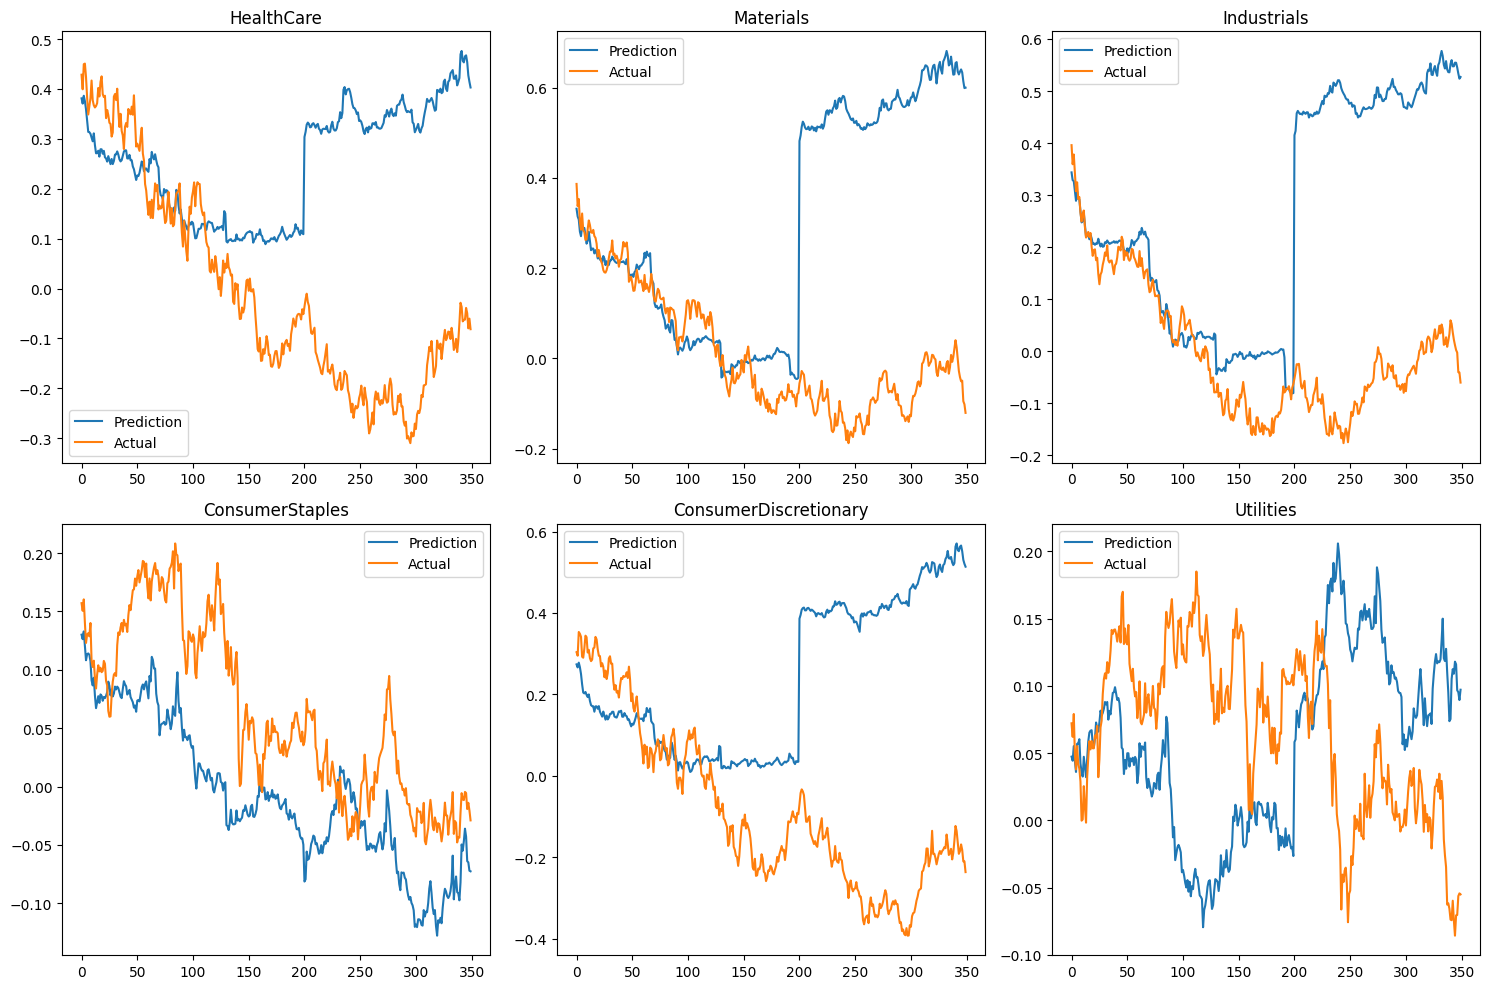

R² Scores for Each Sector:
HealthCare: -2.1356
Materials: -9.5936
Industrials: -7.7762
ConsumerStaples: -0.2495
ConsumerDiscretionary: -4.4822
Utilities: -2.4228
Window 10



Step 0.0/5.0, Loss: 0.086835
Step 1.0/5.0, Loss: 0.028953
Step 2.0/5.0, Loss: 0.024916
Step 3.0/5.0, Loss: 0.023505
Step 4.0/5.0, Loss: 0.022426
Step 4.999/5.0, Loss: 0.021528


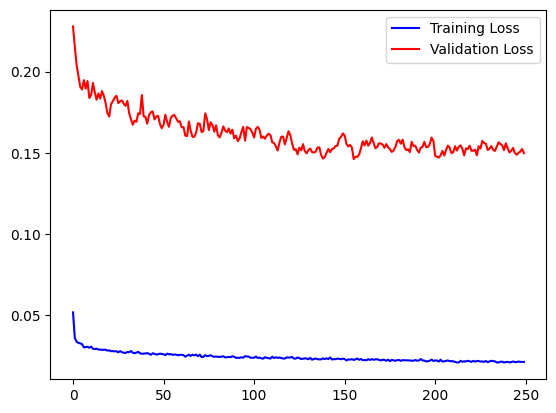

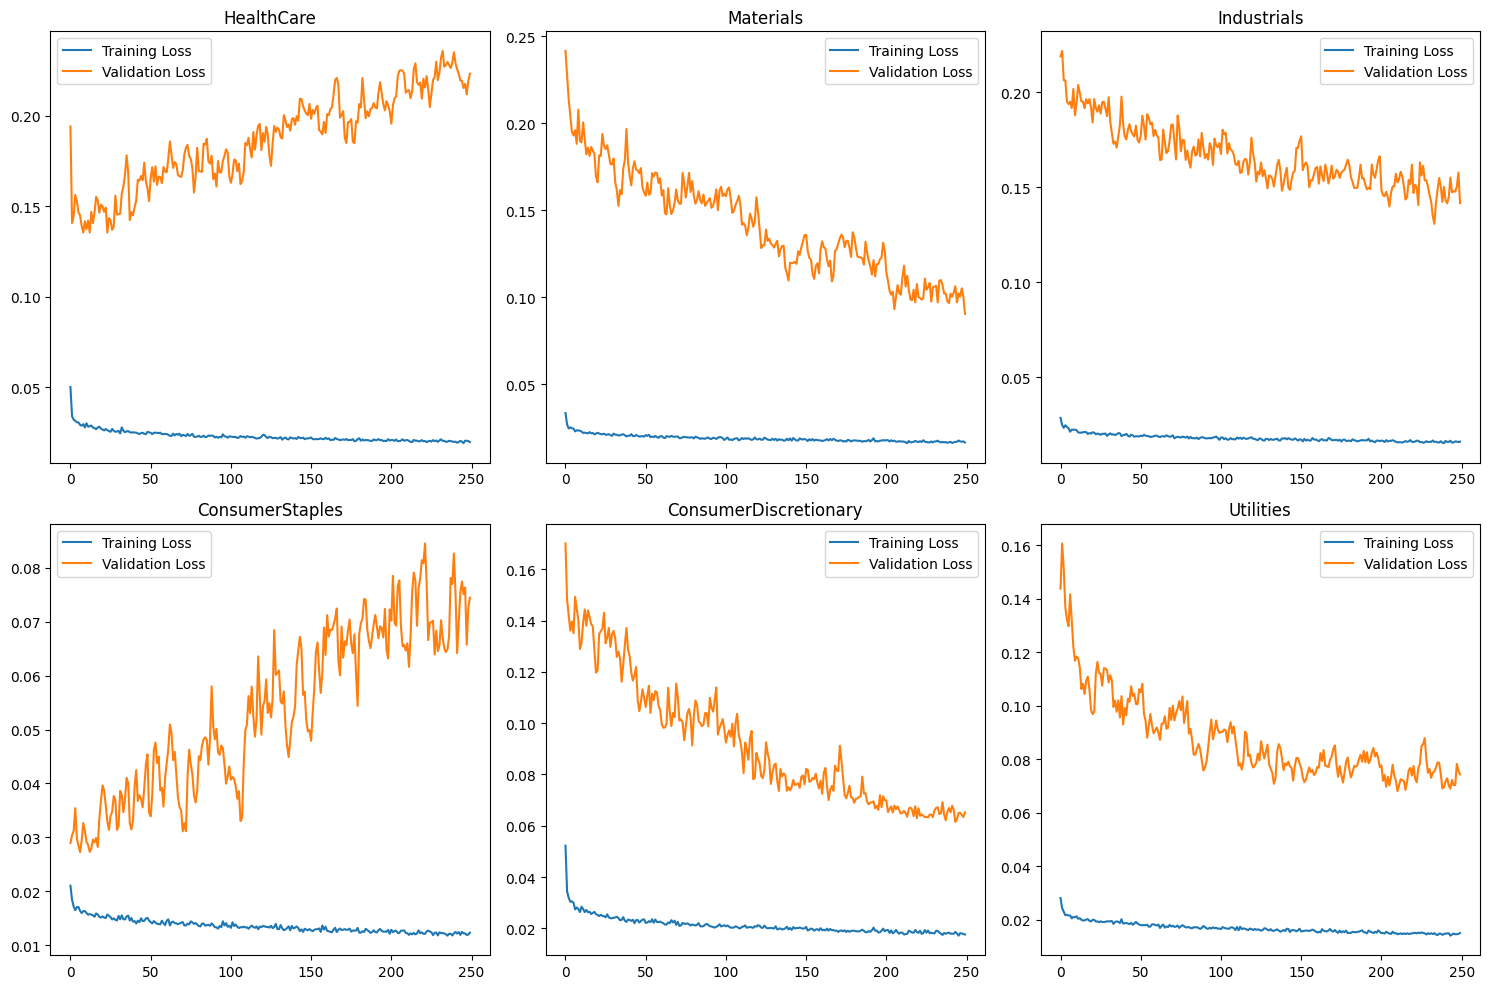

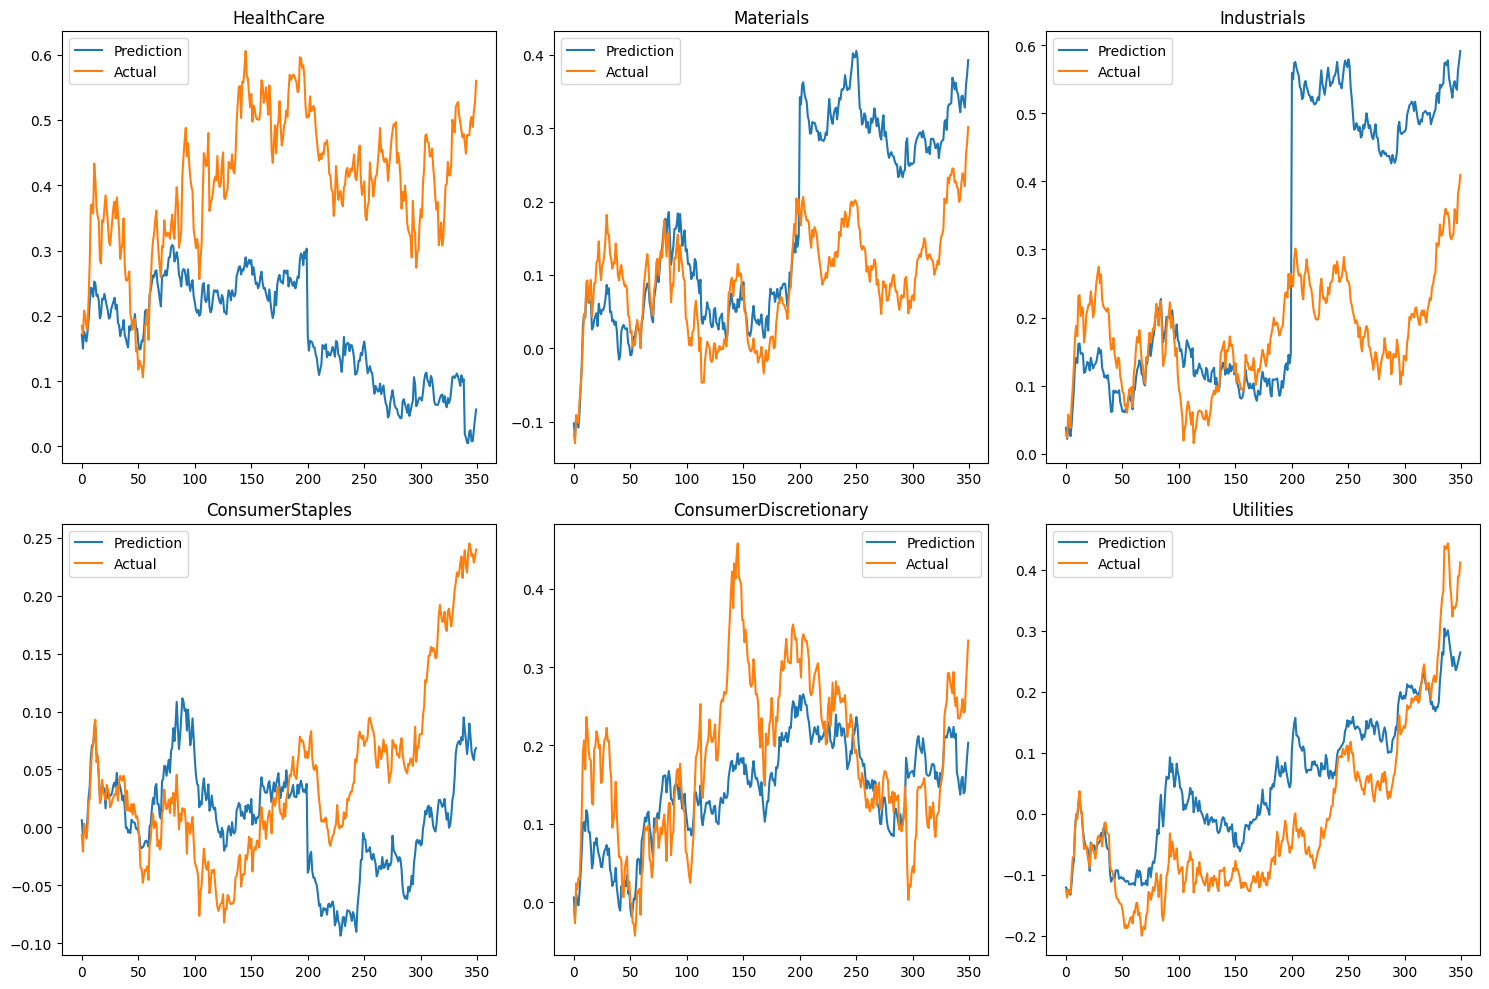

R² Scores for Each Sector:
HealthCare: -5.5285
Materials: -1.6969
Industrials: -5.5866
ConsumerStaples: -0.3511
ConsumerDiscretionary: 0.2821
Utilities: 0.5843


In [ ]:
losses = []
val_losses = []

max_steps = 4000
batch_size = 128
learning_rate = 10 ** -5

input_size = data[0][0].shape[1]  # Number of features in input data
model = Net(input_size, hidden_size=512, num_hid_layers=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.MSELoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

for k in range(windows):
  print(f"Window {k}\n\n\n")
  xtr, ytr, xte, yte = data[k]



  # Training loop
  running_loss = 0.0
  current_losses = []
  current_val_losses = []


  losses_s = {}
  val_losses_s = {}
  sectors = ['HealthCare', 'Materials', 'Industrials', 'ConsumerStaples', 'ConsumerDiscretionary', 'Utilities']
  for sector in sectors:
    losses_s[sector] = []
    val_losses_s[sector] = []


  for step in range(max_steps):
      model.train()
      ix = torch.randint(0, xtr.shape[0], (batch_size,))
      xb, yb = xtr[ix], ytr[ix]  # Batch X, Y

      xb, yb = xb.to(device), yb.to(device)

      pred = model(xb)

      loss = criterion(pred, yb)

      optimizer.zero_grad()
      loss.backward()

      optimizer.step()

      running_loss += loss.item()
      current_losses.append(loss.item())

      with torch.no_grad():
          individualLosses = abs(pred - yb).mean(dim=0)
          for i, sector in enumerate(sectors):
              losses_s[sector] = losses_s.get(sector, []) + [individualLosses[i].item()]


      with torch.no_grad():
          model.eval()
          ixval = torch.randint(0, xte.shape[0], (batch_size,))
          xbval, ybval = xte[ixval], yte[ixval]
          xbval, ybval = xbval.to(device), ybval.to(device)
          predval = model(xbval)
          lossval = criterion(predval, ybval).item()
          current_val_losses.append(lossval)


          individualLosses = abs(predval - ybval).mean(dim=0)
          for i, sector in enumerate(sectors):
              val_losses_s[sector] = val_losses_s.get(sector, []) + [individualLosses[i].item()]


      if step % 1000 == 0 or step == max_steps - 1:
          avg_loss = running_loss / (1000 if step > 0 else 1)
          print(f"Step {step/1000}/{max_steps/1000}, Loss: {avg_loss ** (1/2):.6f}")
          running_loss = 0.0

  scheduler.step() # incremental learning to not lose previous learnings.


  graph_losses = [np.mean(current_losses[i:i+20])**(1/2) for i in range(0, len(current_losses), 20)]
  graph_val_losses = [np.mean(current_val_losses[i:i+20])**(1/2) for i in range(0, len(current_val_losses), 20)]
  plt.plot(graph_losses, color='blue', label='Training Loss')
  plt.plot(graph_val_losses, color='red', label='Validation Loss')
  plt.legend()
  plt.show()


  fig, axes = plt.subplots(2, 3, figsize=(15, 10))

  sector_names = ['HealthCare', 'Materials', 'Industrials',
                  'ConsumerStaples', 'ConsumerDiscretionary', 'Utilities']

  axes = axes.flatten()

  for i in range(6):
      l = losses_s[sector_names[i]]
      val_l = val_losses_s[sector_names[i]]
      ax = axes[i]
      graph_losses = [np.mean(l[i:i+20]) for i in range(0, len(l), 20)]
      graph_val_losses = [np.mean(val_l[i:i+20]) for i in range(0, len(val_l), 20)]



      ax.plot(graph_losses, label=f'Training Loss')
      ax.plot(graph_val_losses, label=f'Validation Loss')
      ax.set_title(sector_names[i])
      ax.legend()

  plt.tight_layout()
  plt.show()

  #Plot Predictions
  model.eval()
  with torch.no_grad():
      xte = xte.to(device)
      pred = model.predict(xte)
      pred = pred.cpu()
  pred_np = pred.numpy()[::-1]
  yte_np = yte.numpy()[::-1]


  fig, axes = plt.subplots(2, 3, figsize=(15, 10))

  axes = axes.flatten()

  r2_scores = {}

  for i in range(6):

      r2 = r2_score(yte_np[:, i], pred_np[:, i])
      r2_scores[sector_names[i]] = r2

      ax = axes[i]
      ax.plot(pred_np[:, i], label=f'Prediction')
      ax.plot(yte_np[:, i], label=f'Actual')
      ax.set_title(sector_names[i])
      ax.legend()

  plt.tight_layout()
  plt.show()

  print("R² Scores for Each Sector:")
  for sector, score in r2_scores.items():
      print(f"{sector}: {score:.4f}")

  losses.append(current_losses)
  val_losses.append(current_val_losses)



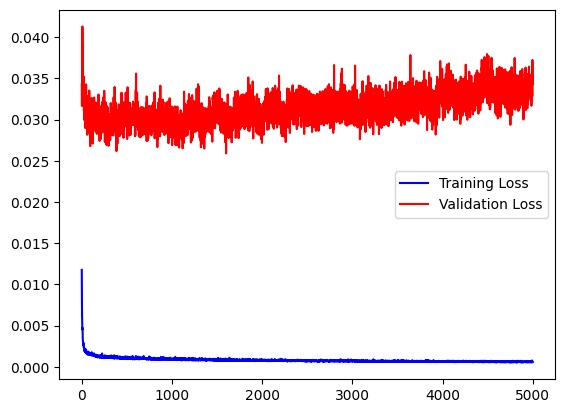

In [ ]:
average_losses = np.mean(losses, axis=0)
average_val_losses = np.mean(val_losses, axis=0)
plt.plot(average_losses, color='blue', label='Training Loss')
plt.plot(average_val_losses, color='red', label='Validation Loss')
plt.legend()
plt.show()
